# Exam Data Science I  
### Exam I in the Summer Term 2025

## General Information

* You have one week to complete the exam. 

* You can use all sources freely (including ChatGPT or similar software)

* You should use the following packages: `numpy, pandas, scipy, scikit-learn/sklearn, matplotlib, seaborn, statsmodels` and Python's native libraries. These are sufficient to solve the exam. If you use other libraries, justify their use.

* Code must be sufficiently commented to be understandable. Write functions whenever you reuse code. In general, follow the guidelines from the lecture. Points may be deducted due to poorly structured or incomprehensible code.

* **Always justify (!)** decisions regarding the choice of plots, hypothesis tests, etc. in writing and **interpret** your results.

* You are **not** allowed to seek help or advice from other people in any way. 

* Please submit the complete repository as a `.zip` file with the name `surname_matrikelnummer.zip` by August 4th, 2025 at 00:00 midnight on StudIP to the folder `Submission - Exam 1`.

* Also add the signed code of conduct (`Eigenständigkeitserklärung.pdf`) to the `.zip` file. 

* If you have any questions, please contact us via Matrix in a timely manner.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy.signal import periodogram
from scipy.stats import zscore, mannwhitneyu
from scipy.stats import shapiro, jarque_bera
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL
from statsmodels.stats.multitest import multipletests
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, StandardScaler, FunctionTransformer
from sklearn.ensemble import IsolationForest
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import plot_tree, export_text, DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

## Tasks and points:

<table>
  <thead>
    <tr>
      <th colspan="4" style="border-right: 1px solid gray;">Task 1 - Data Preprocessing</th>
      <th colspan="5" style="border-right: 1px solid gray;">Task 2 - Plotting</th>
      <th colspan="3" style="border-right: 1px solid gray;">Task 3 - Statistics</th>
      <th colspan="2">Task 4 - Machine Learning </th>
    </tr>
    <tr style="border-bottom: 1px solid gray;">
      <th>Task 1.1</th>
      <th>Task 1.2</th>
      <th>Task 1.3</th>
      <th style="border-right: 1px solid gray;">Task 1.4</th>
      <th>Task 2.1</th>
      <th>Task 2.2</th>
      <th>Task 2.3</th>
      <th>Task 2.4</th>
      <th style="border-right: 1px solid gray;">Task 2.5</th>
      <th>Task 3.1</th>
      <th>Task 3.2</th>
      <th style="border-right: 1px solid gray;">Task 3.3</th>
      <th>Task 4.1</th>
      <th>Task 4.2</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>2 points</td>
      <td>11 points</td>
      <td>4 points</td>
      <td style="border-right: 1px solid gray;">2 points</td>
      <td>2 points</td>
      <td>14 points</td>
      <td>2 points</td>
      <td>4 points</td>
      <td style="border-right: 1px solid gray;">2 points</td>
      <td>6 points</td>
      <td>4 points</td>
      <td style="border-right: 1px solid gray;">7 points</td>
      <td>15 points</td>
      <td>25 points</td>
    </tr>
    <tr>
      <td colspan="4" style="text-align: center; font-weight: bold;border-right: 1px solid gray;">19 points</td>
      <td colspan="5" style="text-align: center; font-weight: bold;border-right: 1px solid gray;">24 points</td>
      <td colspan="3" style="text-align: center; font-weight: bold;border-right: 1px solid gray;">17 points</td>
      <td colspan="2" style="text-align: center; font-weight: bold;">40 points</td>
    </tr>
  </tbody>
</table>


_____
## Task 0: Setup

The exam folder includes a `Dockerfile` that defines all necessary libraries and a `docker-compose.yml` file. The Dockerfile is based on the Jupyter Server image. Use it to build a Docker image and then start a container from that image. Once the container is running, log into the Jupyter Server instance to complete the exam.

Alternatively, you may use the [GWDG Jupyter Cloud service](https://jupyter-cloud.gwdg.de/) with either the GWDG Default Image or the Data Science Jupyter Image.

Important:
If you choose to work in the Jupyter Cloud and to use additional packages, they must be installed within the notebook itself (e.g., using a cell with `!pip install ...`). This ensures your environment can be reproduced during grading.

Code that does not run in the provided Docker container or in the Jupyter Cloud environment will be considered **non-functional** and graded accordingly.

___
## Task 1: Data Preprocessing (18 points)

### Data Description

In this exam, we work with a [dataset](https://arxiv.org/abs/2404.18984) of social interactions and user-generated content from [Bluesky](https://bsky.social/about). The original dataset includes the full posting history of over 4 million users—approximately 81% of all registered accounts—amounting to 235 million posts. To make the data more manageable for analysis, we have pre-aggregated and condensed it into smaller, structured files.

Social media datasets frequently include a sentiment score, a numerical measure indicating the emotional tone of text content such as posts (0: negative, 1: neutral, 2: positive). Since sentiment scores are only available on English-language content in this dataset, we filtered the data to include only English-language posts. Additionally, we limited user interactions to those related exclusively to these filtered posts.

Our aggregated dataset consists out of three subdatasets: author interactions, user interactions and user's post statistics per day.

**Author interactions**
Contains aggregated statistics on how often posts from individual authors received different types of interactions. Each row corresponds to one unique author, identified by a numeric user ID.
- `author`: A unique identifier for each user.
- `replied_count`: The total number of replies received of posts made by the author.
- `reposted_count`: The total number of times the author’s posts were reposted by others.
- `quoted_count`: The number of times the author’s posts were quoted in other users' posts.

**User interactions**
Summarizes the interaction behavior of individual users—how often they engaged with posts by others. Each row represents one unique user, identified by a numeric user ID.
- `user_id`: A unique identifier for each user.
- `replied_count`: The total number of replies the user wrote in response to other posts.
- `reposted_count`: The total number of posts the user reposted.
- `quoted_count`: The number of times the user quoted other users' posts in their own.

**User's post statistics per day**
Provides daily statistics on user-generated posts. Each row represents the posting activity of a single user on a specific day.
- `date`: The calendar date on which the posts were made.
- `user_id`: A unique identifier for the user who authored the posts.
- `post_count`: The number of posts the user made on that day.
- `mean_sentiment`: The average sentiment score of the user’s posts on that day, indicating the overall emotional tone (e.g., positive, neutral, or negative).

### Task 1.1. - Data Loading (2 points)

Load the following datasets into pandas dataframes:
- `author_interaction_stats.csv.gz`
- `user_interaction_stats.csv.gz`
- `user_post_stats_per_day.csv.gz`

Ensure that the `date` column in `user_post_stats_per_day` is interpreted as a date—either during loading or by converting it afterward.

In [2]:
author_interaction_stats = pd.read_csv('data/author_interaction_stats.csv.gz') 
user_interaction_stats = pd.read_csv('data/user_interaction_stats.csv.gz')
user_post_stats_per_day = pd.read_csv('data/user_post_stats_per_day.csv.gz', 
                                      parse_dates=['date'])

### Task 1.2. - Aggregation (11 points)

First, we are interested in trends over time. For this, aggregate the data for `user_post_stats_per_day` over all days and provide summary statistics for each day. 
 - total number of posts per day
 - average sentiment across users per day
 - average sentiment across posts per day (hint: use a weighted mean here)

Make sure that the resulting DataFrame is indexed by the `date` column, stored as a proper `datetime` object.

In [3]:
def weighted_mean(value_col, weight_col):
    def calculate_weighted_mean(group):
        return np.average(group[value_col], weights=group[weight_col])
    return calculate_weighted_mean 

# Group by date and calculate summary statistics
daily_stats = user_post_stats_per_day.groupby('date').agg({
    'post_count': 'sum',  
    'mean_sentiment': 'mean',
})

# Add weighted sentiment separately using apply (faster than lambda in agg)
post_sentiment = user_post_stats_per_day.groupby('date').apply(
    weighted_mean('mean_sentiment', 'post_count')
)

daily_stats['post_sentiment'] = post_sentiment.values
daily_stats.columns = ['posts_per_day', 'user_sentiment', 'post_sentiment']

daily_stats.head()

,posts_per_day,user_sentiment,post_sentiment
date,,,
2023-06-28,12230,1.053866,1.077419
2023-06-29,72447,0.953651,1.000038
2023-06-30,95774,0.968473,0.999022
2023-07-01,212055,1.011609,0.989611
2023-07-02,310227,1.009279,1.008060


Check, if all days within the period are present, or if one day was left out.

In [4]:
expected_range = user_post_stats_per_day['date'].min(), user_post_stats_per_day['date'].max()
actual_days = daily_stats.index.min(), daily_stats.index.max()

if(len(expected_range) - len(actual_days) > 0):
    print(f"Warning: Data is missing for some dates between {expected_range[0]} and {expected_range[1]}.")
else:
    print(f"Data covers the full range from {expected_range[0]} to {expected_range[1]}.")

Data covers the full range from 2023-06-28 00:00:00 to 2024-03-18 00:00:00.


Additionally, we might want to look at individual users. Aggregate the `user_post_stats_per_day` dataset across all days to compute summary statistics for each user. Name the dataframe `user_stats` (easier for future referencing). Include the following features:
 - average sentiment (hint: use a weighted mean) 
 - standard deviation of sentiment (without weighted mean)
 - total number of posts
 - average number of posts per day
 - number of active days
 - date of first post
 - date of last post

Additionally, compute temporal posting behavior using a custom function (note: this may take longer to compute):
- average number of days between posts
- median number of days between posts
- standard deviation of time between posts 
- relative standard deviation or 'coefficient of variation (CV)' of the time between posts (defined as the standard deviation divided by the mean)

The coefficient of variation (CV) provides a normalized measure of posting regularity. A low CV indicates consistent posting intervals, while a high CV suggests irregular or bursty behavior. Unlike the standard deviation alone, the CV accounts for the user's average posting frequency, making comparisons between users more meaningful.

For example, a user who posts every 2 days on average with a standard deviation of 5 days has a CV of 2.5 — indicating high variability. Another user who posts every 20 days with the same standard deviation has a CV of 0.25 — indicating relatively regular behavior.

In [5]:
def calculate_temporal_stats(df):
    """ Calculate temporal posting behavior for all users at once"""
    
    sorted_data = df.sort_values(['user_id', 'date'])
    
    # Calculate the days difference between consecutive posts and add it as a new column
    sorted_data['days_diff'] = sorted_data.groupby('user_id')['date'].diff().dt.days
    
    # Aggregate temporal statistics per user
    temporal_stats = sorted_data.groupby('user_id')['days_diff'].agg([
        ('mean_days_between_posts', 'mean'),
        ('median_days_between_posts', 'median'), 
        ('std_days_between_posts', 'std')
    ]).reset_index()
    
    # Calculate the coefficient of variation
    temporal_stats['cv_days_between_posts'] = (
        temporal_stats['std_days_between_posts'] / 
        temporal_stats['mean_days_between_posts']
    )
    
    return temporal_stats

user_stats = user_post_stats_per_day.groupby('user_id').agg({
    'mean_sentiment': 'std',
    'post_count': ['sum', 'mean'],   
    'date': ['count', 'min', 'max'],   
}).reset_index()

avg_sentiment = user_post_stats_per_day.groupby('user_id').apply(
    weighted_mean('mean_sentiment', 'post_count')
)

user_stats.insert(1, 'avg_sentiment', avg_sentiment.values)

user_stats.columns = ['user_id', 'avg_sentiment', 'std_of_sentiment', 'sum_of_posts', 
                      'avg_number_of_posts_per_day', 'active_days', 'first_post', 'last_post']

user_stats = user_stats.merge(calculate_temporal_stats(user_post_stats_per_day), on='user_id', how='left')

user_stats.head()

,user_id,avg_sentiment,std_of_sentiment,sum_of_posts,avg_number_of_posts_per_day,active_days,first_post,last_post,mean_days_between_posts,median_days_between_posts,std_days_between_posts,cv_days_between_posts
0,0,0.406316,0.235153,1404,11.414634,123,2023-10-18,2024-03-18,1.245902,1.0,2.626349,2.107991
1,1,0.898177,0.507907,512,3.390728,151,2023-07-02,2024-03-18,1.733333,1.0,4.669861,2.694151
2,2,1.208864,0.379932,5727,29.520619,194,2023-07-28,2024-03-18,1.212435,1.0,0.751007,0.619420
3,3,1.217184,0.644854,10,1.250000,8,2024-02-21,2024-03-04,1.714286,1.0,1.112697,0.649073
4,4,1.514687,0.522817,290,2.685185,108,2023-08-20,2024-03-18,1.971963,1.0,1.390384,0.705076


Instead of working with two individual columns for the dates of the first and last post, we want to make use of the information of the total time between them. Calculate the time between the dates of the first and last post in days and add it as a column. Delete the two date columns afterwards.

In [6]:
user_stats['time_between_first_and_last_post'] = user_stats['last_post'] - user_stats['first_post']
user_stats['time_between_first_and_last_post'] = user_stats['time_between_first_and_last_post'].dt.days
user_stats.drop(columns=['first_post', 'last_post'], inplace=True)

user_stats.head()

,user_id,avg_sentiment,std_of_sentiment,sum_of_posts,avg_number_of_posts_per_day,active_days,mean_days_between_posts,median_days_between_posts,std_days_between_posts,cv_days_between_posts,time_between_first_and_last_post
0,0,0.406316,0.235153,1404,11.414634,123,1.245902,1.0,2.626349,2.107991,152
1,1,0.898177,0.507907,512,3.390728,151,1.733333,1.0,4.669861,2.694151,260
2,2,1.208864,0.379932,5727,29.520619,194,1.212435,1.0,0.751007,0.619420,234
3,3,1.217184,0.644854,10,1.250000,8,1.714286,1.0,1.112697,0.649073,12
4,4,1.514687,0.522817,290,2.685185,108,1.971963,1.0,1.390384,0.705076,211


### Task 1.3. - Merging (4 points)

Merge the user-level dataset `user_stats` with interaction data from `user_interaction_stats` and `author_interaction_stats`. Perform the merges in two steps:
1. Left-merge `user_stats` with `user_interaction_stats`.
2. Merge the resulting dataset with `author_interaction_stats`, again using a left join.

This approach ensures that only users who have posted at least one English-language post (i.e., those present in `user_stats`) are included in the final dataset.

Note that both `user_interaction_stats` and `author_interaction_stats` contain columns for the total number of replies, reposts, and quotes. To avoid confusion, append the suffix `_by_others` to the columns from `author_interaction_stats`, as they reflect interactions received by the user (i.e., how others engaged with their posts). This distinction helps clarify whether the user was the actor (interaction made) or the target (interaction received).

In [7]:
author_interaction_stats_renamed = author_interaction_stats.rename(columns={
    'replied_count': 'replied_count_by_others',
    'reposted_count': 'reposted_count_by_others', 
    'quoted_count': 'quoted_count_by_others'
})

user_stats = (user_stats
              .merge(user_interaction_stats, on='user_id', how='left')
              .merge(author_interaction_stats_renamed, left_on='user_id', right_on='author', how='left'))

user_stats.head()

,user_id,avg_sentiment,std_of_sentiment,sum_of_posts,avg_number_of_posts_per_day,active_days,mean_days_between_posts,median_days_between_posts,std_days_between_posts,cv_days_between_posts,time_between_first_and_last_post,replied_count,reposted_count,quoted_count,author,replied_count_by_others,reposted_count_by_others,quoted_count_by_others
0,0,0.406316,0.235153,1404,11.414634,123,1.245902,1.0,2.626349,2.107991,152,76.0,1398.0,306.0,0.0,8.0,4.0,0.0
1,1,0.898177,0.507907,512,3.390728,151,1.733333,1.0,4.669861,2.694151,260,94.0,81.0,18.0,1.0,313.0,505.0,160.0
2,2,1.208864,0.379932,5727,29.520619,194,1.212435,1.0,0.751007,0.619420,234,3674.0,557.0,444.0,2.0,3659.0,936.0,168.0
3,3,1.217184,0.644854,10,1.250000,8,1.714286,1.0,1.112697,0.649073,12,NaN,NaN,NaN,3.0,89.0,340.0,79.0
4,4,1.514687,0.522817,290,2.685185,108,1.971963,1.0,1.390384,0.705076,211,188.0,12.0,10.0,4.0,1788.0,17091.0,2463.0


Some users in the dataset have missing values in their engagement-related columns. These columns include both outgoing interactions and incoming interactions: `"replied_count", "reposted_count", "quoted_count", "replied_count_by_others", "reposted_count_by_others", "quoted_count_by_others"`.

Replace all missing values (NaN) in these columns with 0.

In [8]:
cols = ['replied_count', 'reposted_count', 'quoted_count', 'replied_count_by_others',
        'reposted_count_by_others', 'quoted_count_by_others']
user_stats[cols] = user_stats[cols].fillna(0)

### Task 1.4. - Save Dataframes (2 points)

Since the transformation took some time to compute we want to have it ready in case we close the kernel. Save both aggregated dataframes as .csv files in the first cell and load them again in the second cell. In case your notebook fails, you can resume from the second cell. 

In [9]:
daily_stats.to_csv('data/daily_stats.csv')
user_stats.to_csv('data/user_stats.csv', index=False)

In [10]:
daily_stats = pd.read_csv('data/daily_stats.csv', index_col=0, parse_dates=True)
user_stats = pd.read_csv('data/user_stats.csv')

___
## Task 2: Plotting (24 points)

### Task 2.1. - Posts per day (2 points)

Plot how many posts in total were published on Bluesky each day.

<function matplotlib.pyplot.show(close=None, block=None)>

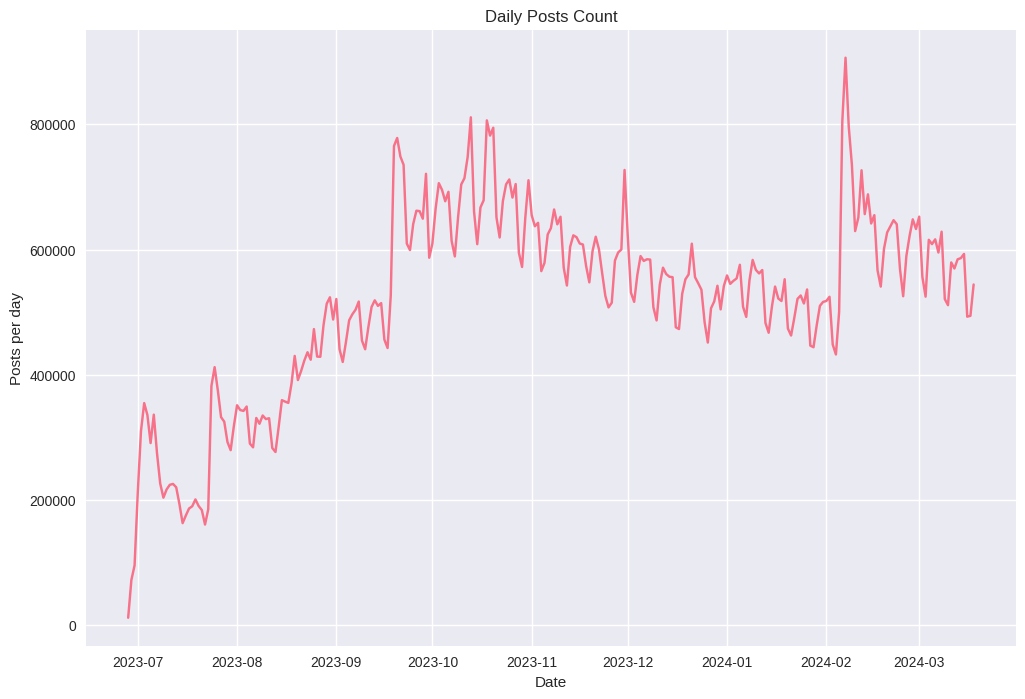

In [11]:
ax = sns.lineplot(daily_stats, x='date', y='posts_per_day')
ax.set(xlabel='Date', ylabel='Posts per day', title='Daily Posts Count')

plt.show

It looks like there is a periodic pattern in the data. Let's find out what is is.

### Task 2.2. - *Weekend whispers* (14 points)

Timeseries data over a quite long timespan (like our posts per day on Bluesky that we just plotted) is behaving the way it is often due to different components: a general trend (is the posting activity going up or down?), a seasonality (is there a repeating pattern?) and residuals (were there some unexpected events?).

One way to disentangle those components is Season-Trend decomposition using LOESS (STL).

STL is a powerful tool to help us understand more in detail what drives the daily posting activity on Bluesky. However, to apply STL to our dataset, we have to specify what kind of periodic pattern or seasonality we expect. Besides guessing, we can have a look at our data and try to find a periodic pattern that we can then give to STL. Feel free though to think about what kind of seasonalities one could expect in data like ours.

#### Task 2.2.1. - Frequency spectrum (6 points)

Explore whether the number of daily posts follows any periodic pattern (i.e., if certain posting behaviors repeat regularly over time). To do this, use the `periodogram` function from `scipy.signal`, which estimates the power spectral density (PSD) of the time series. A PSD shows how much of the total variance ("power") in the timeseries is associated with different frequencies. Although the function outputs frequencies (how often something happens in cycles per day), we're typically more interested in periods (length of one full circle in days), since we're looking for patterns that repeat every X days (hint: frequency = 1 / period). When using the `periodogram` function, we’re mainly interested in the periodical components of the timeseries. You may want to account for trends or non-periodical components using the inbuilt detrending argument.

Plot the power (y-axis) for each number of days until and including 10 (x-axis). What is the main frequency in the data according to your plot? Highlight the peak power of your plot with a differently colored vertical line.

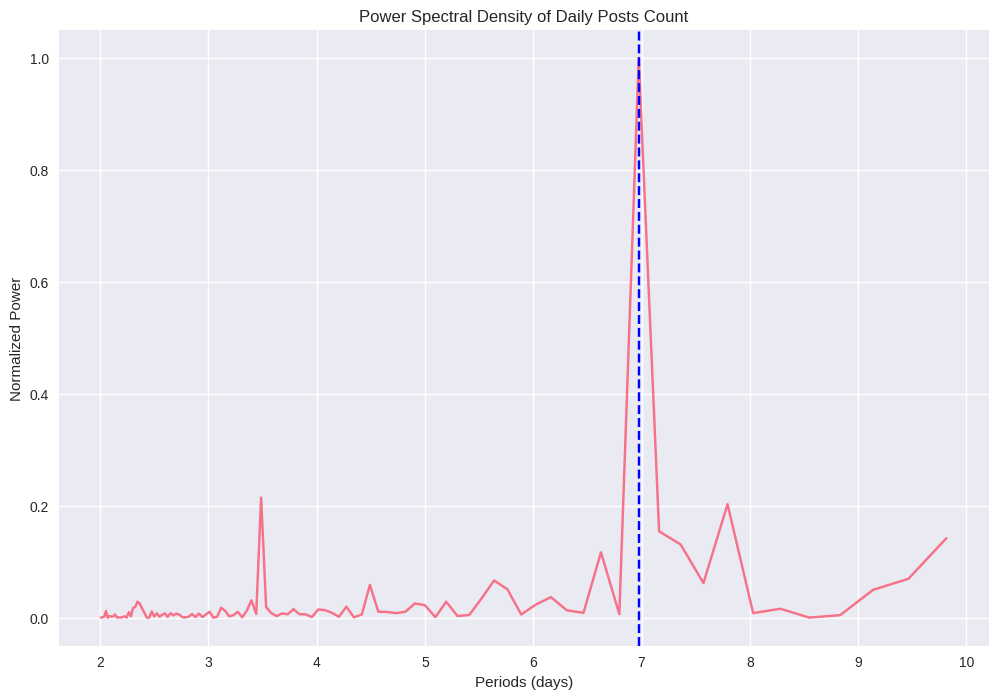

In [12]:
posts_data = daily_stats['posts_per_day'].values

frequencies, power = periodogram(posts_data, detrend='linear')

periods = 1 / frequencies[1:]
cleaned_power = power[1:]

# Filter periods to a maximum of 10 days
filter = periods <= 10
periods_filtered = periods[filter]
power_filtered = cleaned_power[filter]

# Normalize the power 
power_normalized = power_filtered / power_filtered.max()

# Find the peak
peak_period = periods_filtered[np.argmax(power_normalized)]

ax = sns.lineplot(x=periods_filtered, y=power_normalized)
ax.axvline(x=peak_period, color='blue', linestyle='--')
ax.set(xlabel='Periods (days)', ylabel='Normalized Power', title='Power Spectral Density of Daily Posts Count')

plt.show()

#### Task 2.2.2. - Seasonal decomposition (5 points)

Now that you have the period you want to investigate, decompose the time series with the `statsmodels.tsa.seasonal.STL` function to disentangle the seasonal pattern from the overall trend and unexpected bursts or drops (residuals). Use the argument `robust=True` to be less influenced by the sudden jumps in the time-series data. Plot the original timeseries as well as the `trend`, `seasonal`, and `residual` components and extract the `seasonal` time series.

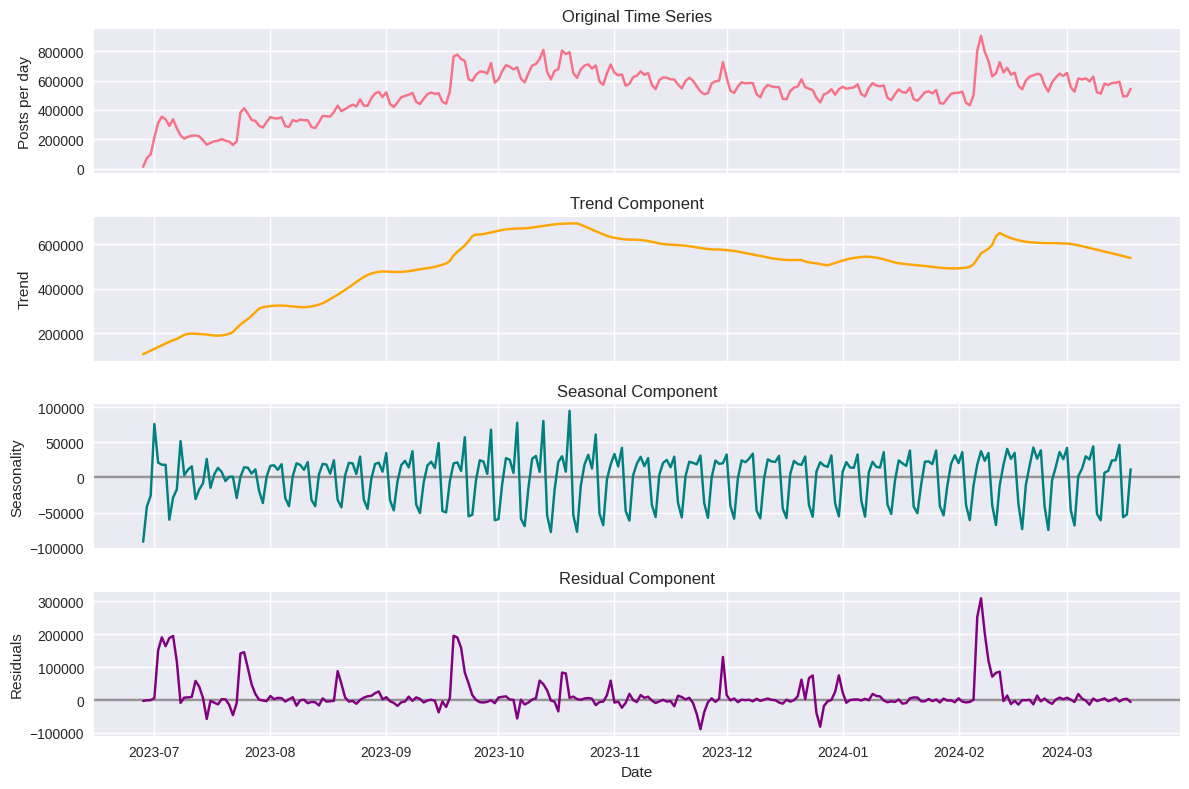

In [13]:
# STL implementation requires an odd seasonal parameter. The detected peak_period gets rounded to the next odd integer
# so the function can be applied to it.
stl = STL(daily_stats['posts_per_day'], seasonal=max(int(peak_period) + (int(peak_period) % 2 == 0), 3), robust=True)
stl_result = stl.fit()

fig, ax = plt.subplots(4, 1, figsize=(12, 8), sharex=True)

ax[0].plot(stl_result.observed)
ax[0].set(ylabel='Posts per day', title='Original Time Series')

ax[1].plot(stl_result.trend, color='orange')
ax[1].set(ylabel='Trend', title='Trend Component')

ax[2].plot(stl_result.seasonal, color='teal', zorder=2)
ax[2].set(ylabel='Seasonality', title='Seasonal Component')
ax[2].axhline(y=0, color='black', linestyle='-', alpha=0.4, zorder=1)

ax[3].plot(stl_result.resid, color='purple', zorder=2)
ax[3].set(xlabel= 'Date', ylabel='Residuals', title='Residual Component')
ax[3].axhline(y=0, color='black', linestyle='-', alpha=0.4, zorder=1)

plt.tight_layout()
plt.show()

seasonal = stl_result.seasonal

A clear weekly seasonal pattern can be observed.

Also a noticeable increase in February 2024, visible in both the trend and residuals, is revealed by the seasonal decomposition. What might explain the increase in activity during this period?

Just by looking at your plot of the STL's trend, give a statement/interpretation regarding the general development of posting activity on Bluesky.

February 2024 was a tumultuous month of major events. Alexei Navalny died on February 16th, February 24th was the second anniversary of Russia's invasion of Ukraine, the Super Bowl was held on February 11th, and the US Presidential Race was in full swing with Republican primaries. Combined with growing dissatisfaction with X/Twitter and Bluesky's positioning as an alternative, the platform experienced an outlying spike in platform traffic.

The trend shows continuous growth in posting activity until November 2023. Since then, there has been a slow decrease in posting activity, with the February 2024 spike as an exception.

_Proofread with the help of AI_

#### Task 2.2.3. - Weekday effect (3 points)

Add a column `day_of_week` to the time series contained in the `seasonal` property of the STL decomposition based on the datetime index. Plot the average seasonal effect for every day of the week as a bar plot. On which days are the users more active and on which days are they least active?

A bar plot is a good option to compare a single metric (seasonal property of STL) across a temporal category (day_of_week).

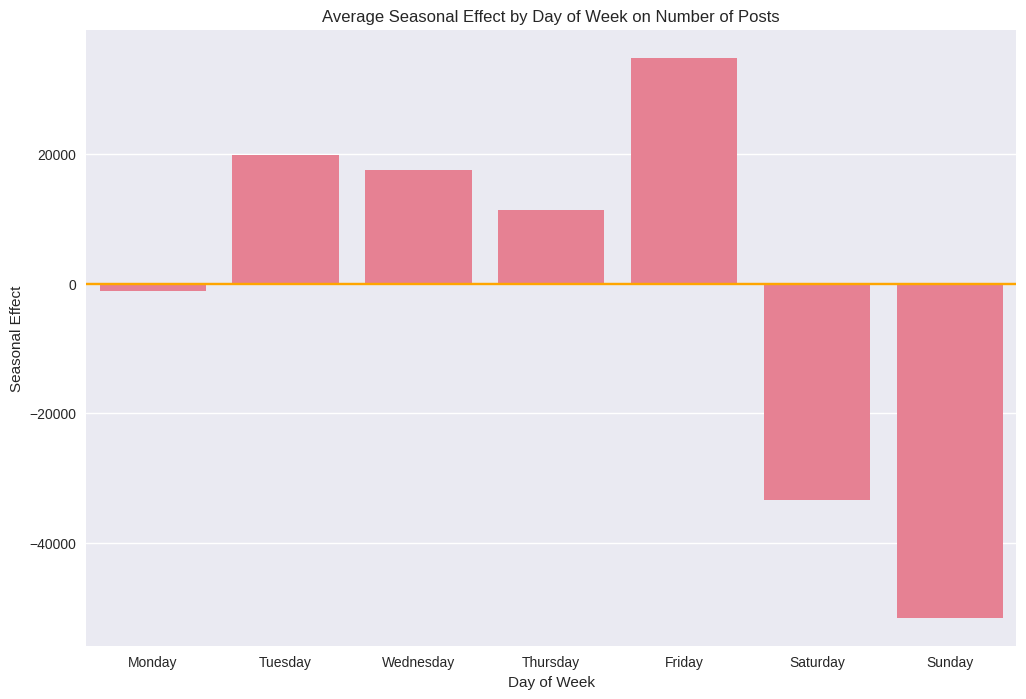

In [14]:
seasonal_df = pd.DataFrame({
    'seasonal_effect': seasonal.values,
    'date': seasonal.index
})

seasonal_df['day_of_week'] = pd.Categorical(
    seasonal_df['date'].dt.day_name(),
    categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
    ordered=True
)

weekday_effects = seasonal_df.groupby('day_of_week', observed=False)['seasonal_effect'].mean()

ax = sns.barplot(x=weekday_effects.index, y=weekday_effects.values)
ax.set(xlabel='Day of Week', ylabel='Seasonal Effect', title='Average Seasonal Effect by Day of Week on Number of Posts')
ax.axhline(y=0, color='orange', linestyle='-')

plt.show()

The activity slightly decreases throughout the week until Thursday with Monday being more or less average. Friday sees a sudden surge of activity and it rapidly falls on the weekend, valleying on Sunday.

### Task 2.3. - Sentiment Data (2 points)

Plot the user sentiment and the average post sentiment over time and calculate the correlation between the two timeseries.

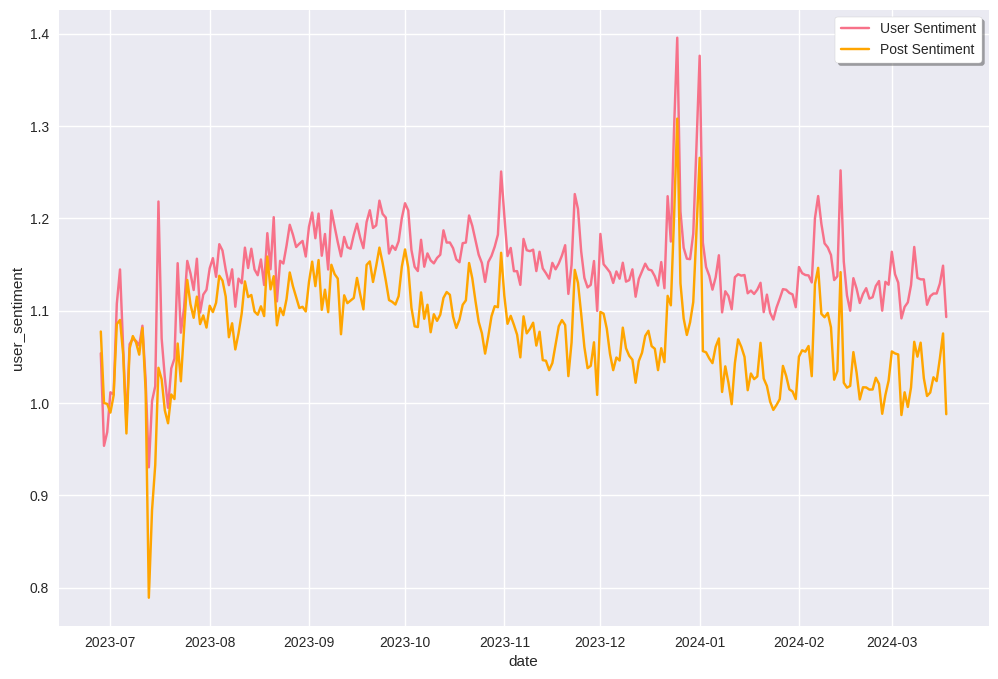

Correlation between user sentiment and post sentiment: 0.8477552083958692
This indicates a moderate positive relationship between the two sentiment measures.
The two sentiment time series move together.


In [15]:
sns.lineplot(data=daily_stats, x='date', y='user_sentiment', label='User Sentiment')
sns.lineplot(data=daily_stats, x='date', y='post_sentiment', color='orange', label='Post Sentiment')

plt.legend(frameon=True, shadow=True, facecolor='white')
plt.show()

correlation = daily_stats['user_sentiment'].corr(daily_stats['post_sentiment'])

# Define correlation bins and corresponding interpretations - Done with the help of Copilot
corr_values = [-1, -0.9, -0.7, -0.5, -0.3, 0, 0.3, 0.5, 0.7, 0.9, 1]
corr_meaning = [
    "very strong negative", "strong negative", "moderate negative", 
    "weak negative", "very weak negative", "no linear",
    "very weak positive", "weak positive", "moderate positive", 
    "strong positive", "very strong positive"
]

interpretation = f"{corr_meaning[np.digitize(correlation, corr_values) - 1]} relationship"

print(f"Correlation between user sentiment and post sentiment: {correlation:}")
print(f"This indicates a {interpretation} between the two sentiment measures.")
print(f"The two sentiment time series move {'together' if correlation > 0 else 'in opposite directions' if correlation < 0 else 'independently'}.")

### Task 2.4. - *Monday Blues?* (4 points)

#### Task 2.4.1. - Seasonal decomposition (2 points)

Repeat the same steps for seasonal decomposition and apply it now to the sentiment data using the function `statsmodels.tsa.seasonal.STL`. You do not need to do the frequency spectrum analysis again. We take the a-priori period of 7 days. 

In [16]:
stl_sentiment = STL(daily_stats['user_sentiment'], seasonal=7, robust=True)
stl_sentiment_result = stl_sentiment.fit()

Plot the decomposition of `trend`, `residual`, and `seasonal` components. 

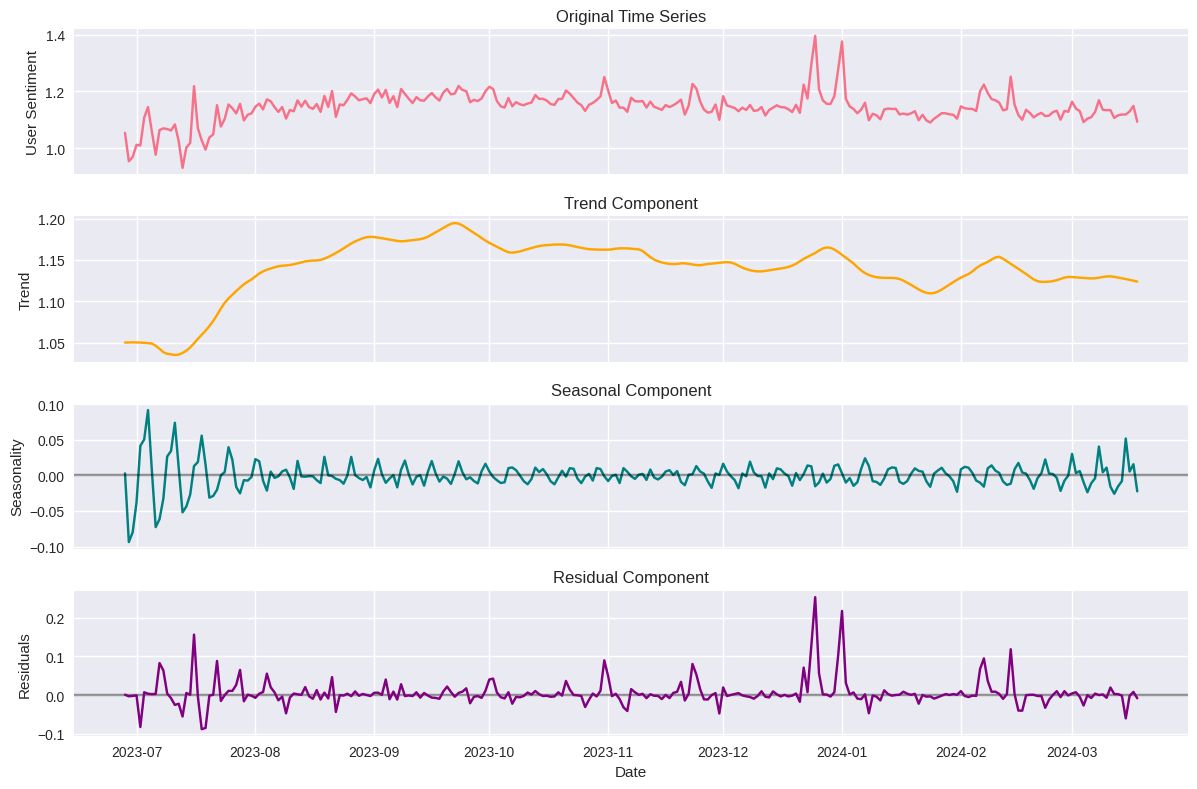

In [17]:
fig, ax = plt.subplots(4, 1, figsize=(12, 8), sharex=True)

ax[0].plot(stl_sentiment_result.observed)
ax[0].set(ylabel='User Sentiment', title='Original Time Series')

ax[1].plot(stl_sentiment_result.trend, color='orange')
ax[1].set(ylabel='Trend', title='Trend Component')

ax[2].plot(stl_sentiment_result.seasonal, color='teal', zorder=1)
ax[2].set(ylabel='Seasonality', title='Seasonal Component')
ax[2].axhline(y=0, color='black', linestyle='-', alpha=0.4, zorder=1)

ax[3].plot(stl_sentiment_result.resid, color='purple')
ax[3].set(xlabel='Date', ylabel='Residuals', title='Residual Component')
ax[3].axhline(y=0, color='black', linestyle='-', alpha=0.4, zorder=1)

plt.tight_layout()
plt.show()

seasonal_sentiment = stl_sentiment_result.seasonal

Name two events that can be seen in the residuals.

Summer 2023 volatility: Between July and August of 2023 we can observe high volatility in sentiment with major fluctuations. 

Winter of 2023/24: A major positive sentiment spike can be observed between December 2023 and January 2024. 

#### Task 2.4.2. - Weekday effect (2 points)

Plot the effect of weekday onto the average sentiment. What do you see?

Like in Task 2.2.3. a bar plot is a good option. We are yet again comparing a single metric (average sentiment) across a temporal category (day_of_week).

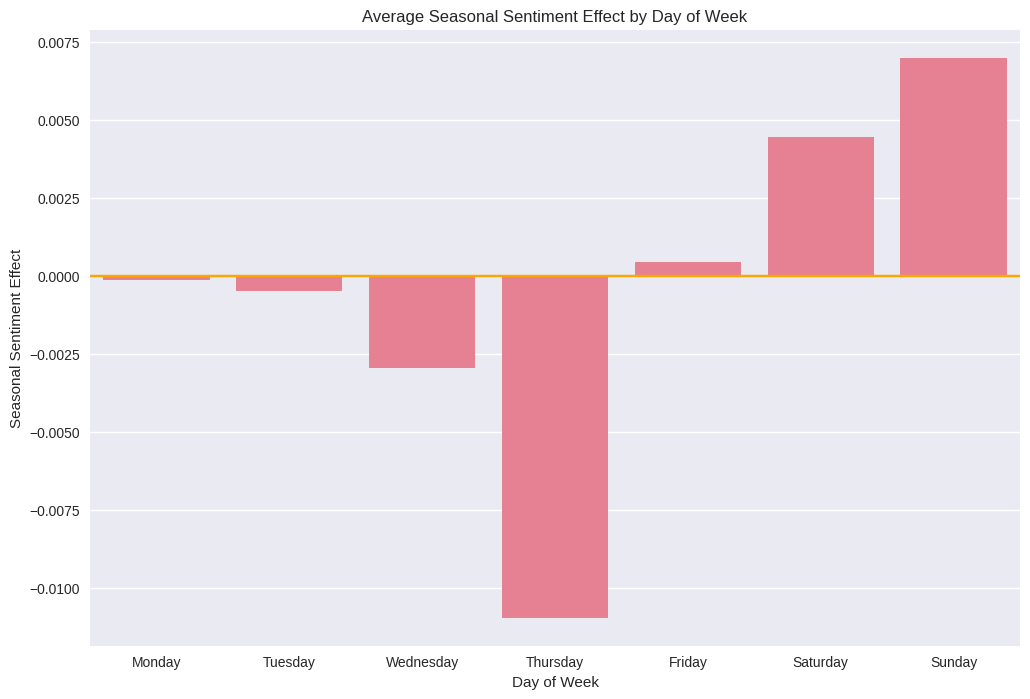

In [18]:
seasonal_sentiment_df = pd.DataFrame({
    'seasonal_effect': seasonal_sentiment.values,
    'date': seasonal_sentiment.index
})

seasonal_sentiment_df['day_of_week'] = pd.Categorical(
    seasonal_sentiment_df['date'].dt.day_name(),
    categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
    ordered=True
)

sentiment_weekday_effects = seasonal_sentiment_df.groupby('day_of_week', observed=False)['seasonal_effect'].mean()

ax = sns.barplot(x=sentiment_weekday_effects.index, y=sentiment_weekday_effects.values)
ax.set(xlabel='Day of Week', ylabel='Seasonal Sentiment Effect', title='Average Seasonal Sentiment Effect by Day of Week')
ax.axhline(y=0, color='orange', linestyle='-')

plt.show()

The sentiment gets progressively worse during the week until it valleys on Thursday and then improves until it peaks on Sunday. So during the week the reception to the posts are considerably worse than during the weekend. As we can see in Task 2.2.3. Sunday the least active day that also has the highest average sentiment.

### Task 2.5. - Highly active users (2 points)

Last but not least, lets look at the distribution of the average number of posts per day of Bluesky's users. Transform the data so that a distribution is visible. What do you see?

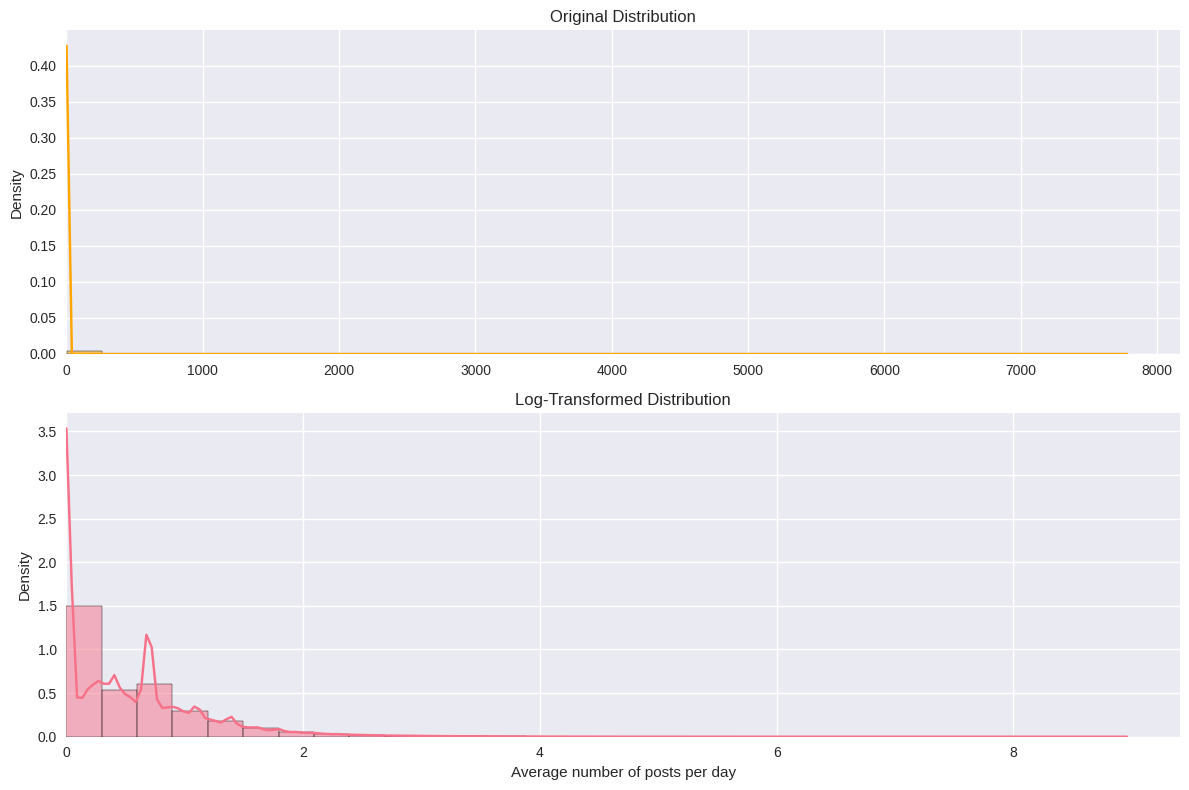

In [19]:
avg_posts = user_stats['avg_number_of_posts_per_day'].values
log_avg_posts = np.log(user_stats['avg_number_of_posts_per_day'] + 1e-10)

fig, ax = plt.subplots(2, 1)

sns.histplot(x=avg_posts, bins=30, kde=True, stat='density', color='orange', label='Posts Distribution', ax=ax[0], zorder=2)
ax[0].set(ylabel='Density', title='Original Distribution') 
ax[0].set_xlim(left=0)

sns.histplot(x=log_avg_posts, bins=30, kde=True, stat='density', label='Posts Distribution', ax=ax[1], zorder=2)
ax[1].set(xlabel='Average number of posts per day', ylabel='Density', title='Log-Transformed Distribution') 
ax[1].set_xlim(left=0)

plt.tight_layout()
plt.show()

The original data of the average number of posts per day of any user is heavily right-skewed with extreme outliers. Most users post very little, and a few users post a lot. That's why we can observe a narrow peak near zero, where most users are, and a very long, flat tail towards the right. 

To remove the skewness, I applied a log-transformation (adding a small value to every average because log(0) is undefined). The resulting distribution shows at least 3 user types: inactive users (far left), regular user (middle with peak), powers users/potential bots (right tail). It exhibits a form of participation inequality.

___
## Task 3: Statistics (17 points)

### Task 3.1. - Weekday effects on posting behaviour (6 points)

To see if the effects of the weekday onto the number of posts is significant, we use a linear regression to gain a statistical measure. Regress the extracted seasonal pattern from the day of the week. Read yourself about the dummy variable trap and avoid it by **not** including an intercept. Think about what this means or how to interpret the model and its results then respectively and remember what the seasonal component reflects (or read again about it). Then report the overall statistic for the model, and the statistics for the effects of the different weekdays, using as significance level an &alpha; of 0.05, and interpret the results. 

In [20]:
seasonal_posts_df = pd.DataFrame({
    'seasonal_effect': seasonal.values,
    'date': seasonal.index
})

seasonal_posts_df['day_of_week'] = pd.Categorical(
    seasonal_posts_df['date'].dt.day_name(),
    categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
    ordered=True
)

seasonal_posts_X = pd.get_dummies(seasonal_posts_df['day_of_week'], drop_first=False)
seasonal_posts_Y = seasonal_posts_df['seasonal_effect'].values

seasonal_posts_model = sm.OLS(seasonal_posts_Y, seasonal_posts_X).fit()

print(seasonal_posts_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.690
Model:                            OLS   Adj. R-squared:                  0.682
Method:                 Least Squares   F-statistic:                     95.57
Date:                Sun, 03 Aug 2025   Prob (F-statistic):           1.13e-62
Time:                        23:36:24   Log-Likelihood:                -2992.1
No. Observations:                 265   AIC:                             5998.
Df Residuals:                     258   BIC:                             6023.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Monday     -1073.7006   3186.327     -0.337      0.7

Model equation:\
seasonal_effect = β₁(Monday) + β₂(Tuesday) + ... + β₇(Sunday) + ε\
where β₁ shows the average seasonal effect for Mondays, β₂ for Tuesdays, and so on.\\

The individual coefficient indicates whether that weekday has above-trend or below-trend activity. Monday, for instance, has a negative coefficient of -1073.7006, meaning that there are ~1074 fewer posts on Mondays. This number climbs to a coefficient of 30,000+ on Thursday and then drops down to -52.000 on Sunday. This is consistent with the Plot in Task 2.2.3. 

All p-values besides Monday are < 0.001, showing strong statistical significance. There's a very small chance that these effects are due to random variation. On Monday, however, we can see a p-value of 0.736. Because the seasonal component has natural fluctuation and the deviation on Monday is too small to be statistically distinguishable from that fluctuation.


As rigorous statisticians we need to do a correction for multiple comparisons since we are testing 7 times. Do a correction for multiple comparisons. Are the weekday effects still significant?

In [21]:
def bonferroni_correction_analysis(model, alpha=0.05):
    """ Apply Bonferroni correction to OLS model results and return detailed analysis."""
    
    p_values = model.pvalues
    
    # Apply Bonferroni correction
    rejected, p_adjusted, alpha_sidak, alpha_bonf = multipletests(
        p_values, alpha=alpha, method='bonferroni'
    )
    
    # Create results dataframe
    results_df = pd.DataFrame({
        'feature': p_values.index,
        'coefficient': model.params.values,
        'p_value_original': p_values.values,
        'p_value_adjusted': p_adjusted,
        'significant_original': p_values < alpha,
        'significant_adjusted': rejected,
    })
    
    return results_df

bonferroni_seasonal_posts = bonferroni_correction_analysis(seasonal_posts_model, alpha=0.05)

print("\nMultiple comparisons correction results:")
print(bonferroni_seasonal_posts.to_string(index=False))


Multiple comparisons correction results:
  feature   coefficient  p_value_original  p_value_adjusted  significant_original  significant_adjusted
   Monday  -1073.700604      7.364125e-01      1.000000e+00                 False                 False
  Tuesday  19838.814922      3.036830e-09      2.125781e-08                  True                  True
Wednesday  17530.162726      9.056926e-08      6.339848e-07                  True                  True
 Thursday  11444.993534      3.929749e-04      2.750824e-03                  True                  True
   Friday  34926.691352      3.318989e-23      2.323292e-22                  True                  True
 Saturday -33436.503663      1.097618e-21      7.683325e-21                  True                  True
   Sunday -51597.464679      3.572637e-41      2.500846e-40                  True                  True


The same weekday effects are statistically significant after applying a Bonferri correction. 

### Task 3.2. - Weekday effects on user sentiment (4 points)

We repeat the procedure for the sentiment analysis to see if we can actually infer patterns of effects per weekday. Does this still hold after correction for multiple comparisons? Are weekdays having a stronger effect on posts or sentiment?

In [22]:
seasonal_sentiment_X = pd.get_dummies(seasonal_sentiment_df['day_of_week'], drop_first=False)
seasonal_sentiment_Y = seasonal_sentiment_df['seasonal_effect'].values

seasonal_sentiment_model = sm.OLS(seasonal_sentiment_Y, seasonal_sentiment_X).fit()

print(seasonal_sentiment_model.summary())

bonferroni_seasonal_sentiment = bonferroni_correction_analysis(seasonal_sentiment_model, alpha=0.05)

print("\nMultiple comparisons correction results:")
print(bonferroni_seasonal_sentiment.to_string(index=False))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     3.866
Date:                Sun, 03 Aug 2025   Prob (F-statistic):            0.00103
Time:                        23:36:24   Log-Likelihood:                 692.73
No. Observations:                 265   AIC:                            -1371.
Df Residuals:                     258   BIC:                            -1346.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Monday        -0.0001      0.003     -0.041      0.9

We can infer a similar pattern to the weekday effects on posts for weekday effects on sentiment. From Monday through Thursday, we see negative sentiment scores (valleying on Thursday) and a rise in sentiment scores on the Weekend. This still holds up after applying the Bonferroni correction. 

### Task 3.3. - Bot-like behavior on user sentiment (7 points)

Now we will have a look at the user data. In the preprocessing part, we have already created a dataframe with features characterising users. Since some users are posting way more than the average number of posts per day, it looks like bots are being on the network that create large number of posts. Unfortunately, our dataset doesn't provide labels classifying whether a user is a bot or not. But since we have previously created a list of features, we can now try to make use of them to come up with some rules.

Create a new column `is_bot` in the dataset based on the following logic:\
A user is labeled as a bot if the two following conditions are met:
1. Activity is very high: `post_count_total` > 1000
2. Posting frequency is too regular: `cv_days_between_posts` < 0.5

In Task 1.2, several features were computed based on the time between posts for each user: `"mean_days_between_posts", "median_days_between_posts", "std_days_between_posts", "cv_days_between_posts"`.

However, some users are missing one or more of these values — for example, users who posted only once or not at all. Remove all rows from the dataset where any of these four features is missing (NaN).

In [23]:
def bot_checker(df=user_stats):
    if(df['sum_of_posts'] > 1000) and (df['cv_days_between_posts'] < 0.5):
        return 1
    return 0

user_stats['is_bot'] = user_stats.apply(bot_checker, axis=1)

features_to_remove = ['mean_days_between_posts', 'median_days_between_posts',
                      'std_days_between_posts', 'cv_days_between_posts']

user_stats = user_stats.dropna(subset=features_to_remove)

user_stats.head()

,user_id,avg_sentiment,std_of_sentiment,sum_of_posts,avg_number_of_posts_per_day,active_days,mean_days_between_posts,median_days_between_posts,std_days_between_posts,cv_days_between_posts,time_between_first_and_last_post,replied_count,reposted_count,quoted_count,author,replied_count_by_others,reposted_count_by_others,quoted_count_by_others,is_bot
0,0,0.406316,0.235153,1404,11.414634,123,1.245902,1.0,2.626349,2.107991,152,76.0,1398.0,306.0,0.0,8.0,4.0,0.0,0
1,1,0.898177,0.507907,512,3.390728,151,1.733333,1.0,4.669861,2.694151,260,94.0,81.0,18.0,1.0,313.0,505.0,160.0,0
2,2,1.208864,0.379932,5727,29.520619,194,1.212435,1.0,0.751007,0.619420,234,3674.0,557.0,444.0,2.0,3659.0,936.0,168.0,0
3,3,1.217184,0.644854,10,1.250000,8,1.714286,1.0,1.112697,0.649073,12,0.0,0.0,0.0,3.0,89.0,340.0,79.0,0
4,4,1.514687,0.522817,290,2.685185,108,1.971963,1.0,1.390384,0.705076,211,188.0,12.0,10.0,4.0,1788.0,17091.0,2463.0,0


Test whether bots and non-bots differ significantly in the following metrics:
1. `sentiment_mean`
2. `sentiment_std`

For each metric:
- Plot both distributions (bots and non-bots) for both metrics with appropriate plots.
- Choose an appropriate test (parametric, non-parametric, or bootstrapping)
- Justify and check the assumptions of your test
- Report your p-value, and whether it is significant.

Histograms are generally the go-to choice for showing the distribution of a single variable (sentiment_mean or sentiment_std in this case). It's also a way to visually inspect their shape and spread to help in assessing the assumption of certain statistical tests. 

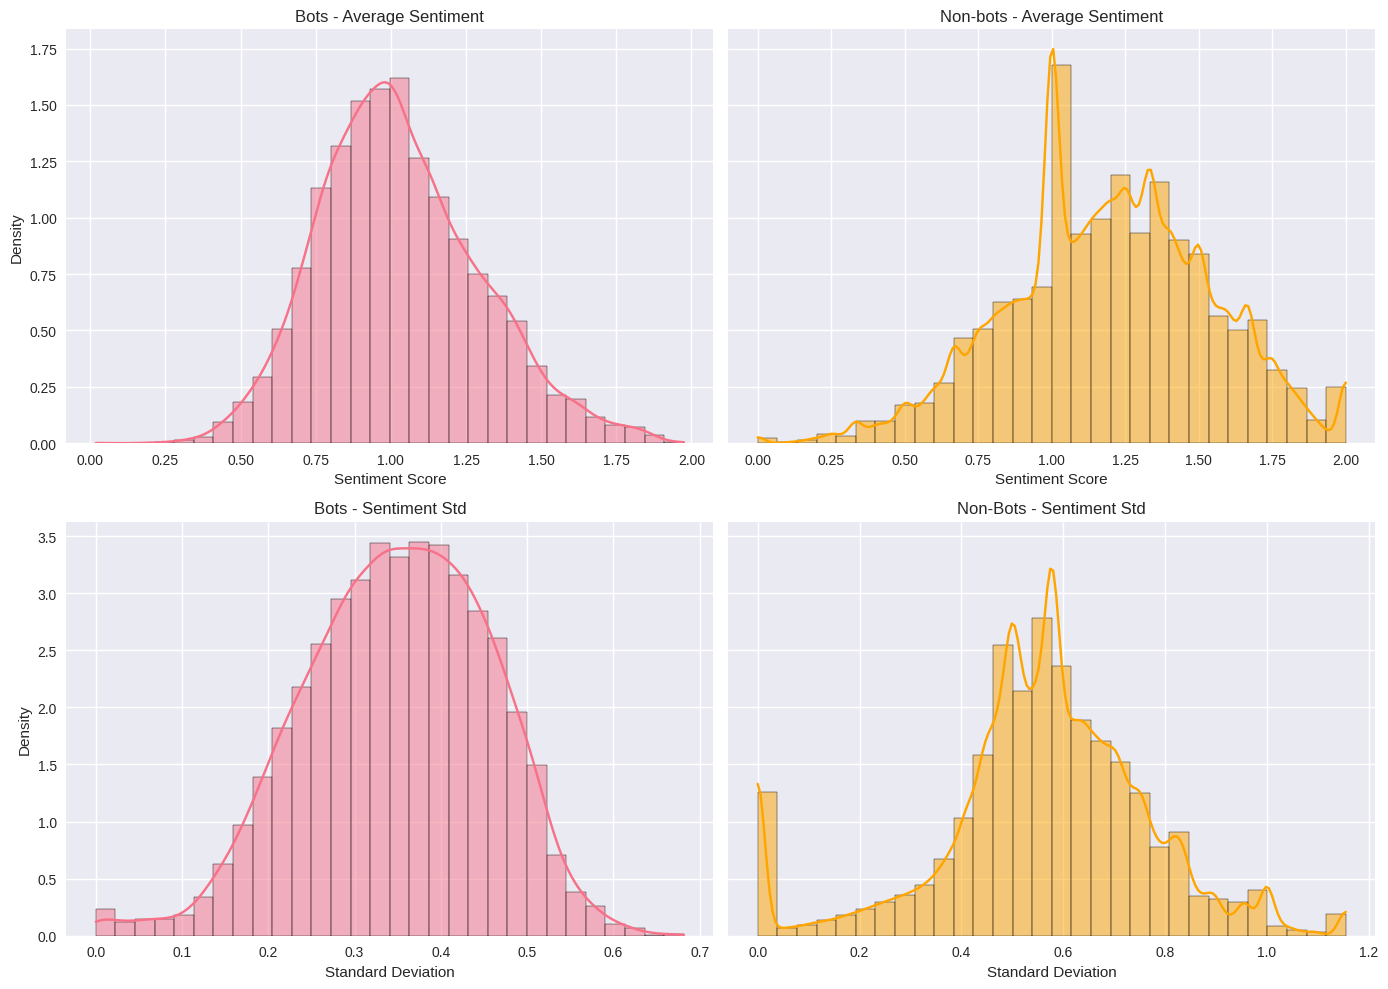

=== Shapiro-Wilk Normality Test Results ===
Bot sentiment normality p-value: 0.00
Non-Bot sentiment normality p-value: 0.00
Bot std normality p-value: 0.00
Non-Bot std normality p-value: 0.00

=== Mann-Whitney U Test Results ===
Average Sentiment Analysis:
Mann-Whitney U test p-value: 0.00
Effect size: 0.3109908863859788 (medium)

Standard Deviation of Sentiment Analysis:
Mann-Whitney U test p-value: 0.00
Effect size: 0.6896381711702894 (large)


In [24]:
def interpret_effect_size(r):
    """Interpret effect size according to Cohen's conventions"""
    abs_r = abs(r)
    if abs_r < 0.1:
        return "negligible"
    elif abs_r < 0.3:
        return "small"
    elif abs_r < 0.5:
        return "medium"
    else:
        return "large"

bot_sentiment_mean = user_stats['avg_sentiment'][user_stats['is_bot'] == 1].values
non_bot_sentiment_mean = user_stats['avg_sentiment'][user_stats['is_bot'] == 0].values

bot_std = user_stats['std_of_sentiment'][user_stats['is_bot'] == 1].values
non_bot_std = user_stats['std_of_sentiment'][user_stats['is_bot'] == 0].values

fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharey='row')

# Average Sentiment plots
sns.histplot(bot_sentiment_mean, bins=30, kde=True, stat='density', ax=axes[0,0])
sns.histplot(non_bot_sentiment_mean, bins=30, kde=True, stat='density', 
             ax=axes[0,1], color='orange')

axes[0,0].set_title('Bots - Average Sentiment')
axes[0,0].set_ylabel('Density')
axes[0,0].set_xlabel('Sentiment Score')

axes[0,1].set_title('Non-bots - Average Sentiment') 
axes[0,1].set_xlabel('Sentiment Score')

# Standard Deviation of Sentiment plots
sns.histplot(bot_std, bins=30, kde=True, stat='density', ax=axes[1,0])
sns.histplot(non_bot_std, bins=30, kde=True, stat='density', 
             ax=axes[1,1], color='orange')

axes[1,0].set_title('Bots - Sentiment Std')
axes[1,0].set_ylabel('Density')
axes[1,0].set_xlabel('Standard Deviation')

axes[1,1].set_title('Non-Bots - Sentiment Std')
axes[1,1].set_xlabel('Standard Deviation')

plt.tight_layout()
plt.show()

# Normality tests for test choice
shapiro_sentiment_bot = shapiro(bot_sentiment_mean)  
shapiro_sentiment_nonbot = shapiro(non_bot_sentiment_mean)

shapiro_std_bot = shapiro(bot_std)
shapiro_std_nonbot = shapiro(non_bot_std)

print("=== Shapiro-Wilk Normality Test Results ===")
print(f"Bot sentiment normality p-value: {shapiro_sentiment_bot.pvalue:.2f}")
print(f"Non-Bot sentiment normality p-value: {shapiro_sentiment_nonbot.pvalue:.2f}")
print(f"Bot std normality p-value: {shapiro_std_bot.pvalue:.2f}")
print(f"Non-Bot std normality p-value: {shapiro_std_nonbot.pvalue:.2f}")

# Mann-Whitney U test for non-parametric comparison
sentiment_test = mannwhitneyu(bot_sentiment_mean, non_bot_sentiment_mean, 
                              alternative='two-sided')
effect_size_sentiment = (1 - (2 * sentiment_test.statistic) / 
                         (len(bot_sentiment_mean) * len(non_bot_sentiment_mean)))

std_test = mannwhitneyu(bot_std, non_bot_std, alternative='two-sided')
effect_size_std = 1 - (2 * std_test.statistic) / (len(bot_std) * len(non_bot_std))

print("\n=== Mann-Whitney U Test Results ===")
print("Average Sentiment Analysis:")
print(f"Mann-Whitney U test p-value: {sentiment_test.pvalue:.2f}")
print(f"Effect size: {effect_size_sentiment} ({interpret_effect_size(effect_size_sentiment)})")
print("\nStandard Deviation of Sentiment Analysis:")
print(f"Mann-Whitney U test p-value: {std_test.pvalue:.2f}")
print(f"Effect size: {effect_size_std} ({interpret_effect_size(effect_size_std)})")


Visual inspection through the plots shows that the bot sentiment and standard deviation appear approximately normal and have similar shapes. The Shapiro-Wilk test, however, rejects normality (p-value < 0.05). Due to the uncertainty, we should use a test that works regardless of the distribution shape. Furthermore, the data are independent of each other, and the dependent variables are continuous. 
All four assumptions of the Mann-Whitney U Test are satisfied. 

The p-values for the Mann-Whitney U tests we conducted are < 0.05, so there is a statistically significant difference between the two observed variables. To determine whether that difference matters, we calculated the effect size for the tests: both show meaningful differences. If the effect size were < 0.1, there might be a statistically significant difference, but we would be unable to reliably detect that difference. 


___ 
## Task 4: Machine Learning (40 points)

### Task 4.1. - Unsupervised learning (15 points)

Instead of relying on hardcoded rules to detect bots, we now turn to unsupervised machine learning to identify users with abnormal behavior patterns.

While we could use our rule-based bot labels to train a supervised model, doing so would only teach the model to replicate the very rules we defined — essentially learning nothing new. Since we are not fully confident that these rules accurately capture what defines a bot, we choose not to use them as ground truth.

However, without labeled examples of bots and non-bots, we cannot apply supervised learning. This is where unsupervised learning methods, such as clustering or anomaly detection, become valuable. These approaches allow us to discover potentially suspicious user behavior without predefined labels and may help surface new patterns that our handcrafted rules might miss.

For this task, we use the Isolation Forest algorithm, a popular method for anomaly detection. An Isolation Forest is an ensemble of many Isolation Trees, hence the name "forest." An ensemble is a technique that combines multiple models to create a stronger, more robust model. While individual models—especially when randomized—may make mistakes or follow inefficient paths, combining many of them (e.g., by averaging or voting) helps reduce the influence of these individual errors and amplify consistent patterns across models.

An Isolation Tree is a [tree](https://en.wikipedia.org/wiki/Tree_(abstract_data_type)) that works by recursively partitioning the data. At each node, it:
- Randomly selects a feature.
- Chooses a random split value between that feature's minimum and maximum within the current subset.
- Splits the data accordingly and repeats the process for each subgroup.

This continues until each data point is isolated in its own leaf or a maximum depth is reached. The intuition behind the method is that anomalies are easier to isolate—they require fewer splits to be separated from the rest of the data.

In the Isolation Forest, we compute an anomaly score for each data point based on the average path length (i.e., number of splits) it takes to isolate that point across all trees. Points with shorter average path lengths are considered more anomalous.

You can read more about Isolation Forests [here](https://www.datacamp.com/tutorial/isolation-forest).

#### Task 4.1.1. - Feature inspection (1 point)

To prepare for unsupervised learning, you need to extract a clean set of numerical features that describe user behavior and engagement. Select and keep only the following columns, which represent meaningful behavioral and engagement metrics: `'post_count_total', 'sentiment_mean', 'sentiment_std', 'replied_count', 'reposted_count', 'quoted_count', 'days_active', 'cv_days_between_posts', 'replied_count_by_others', 'reposted_count_by_others', 'quoted_count_by_others'`

In [25]:
numerical_features = ['sum_of_posts', 'avg_sentiment', 'std_of_sentiment', 
                      'replied_count', 'reposted_count', 'quoted_count', 'active_days', 
                      'cv_days_between_posts', 'replied_count_by_others', 'reposted_count_by_others', 
                      'quoted_count_by_others']

numerical_features_df = user_stats[numerical_features]

numerical_features_df.head()

,sum_of_posts,avg_sentiment,std_of_sentiment,replied_count,reposted_count,quoted_count,active_days,cv_days_between_posts,replied_count_by_others,reposted_count_by_others,quoted_count_by_others
0,1404,0.406316,0.235153,76.0,1398.0,306.0,123,2.107991,8.0,4.0,0.0
1,512,0.898177,0.507907,94.0,81.0,18.0,151,2.694151,313.0,505.0,160.0
2,5727,1.208864,0.379932,3674.0,557.0,444.0,194,0.619420,3659.0,936.0,168.0
3,10,1.217184,0.644854,0.0,0.0,0.0,8,0.649073,89.0,340.0,79.0
4,290,1.514687,0.522817,188.0,12.0,10.0,108,0.705076,1788.0,17091.0,2463.0


#### Task 4.1.3. - IsolationForest (4 points)
Use the selected behavioral and sentiment-based features to detect anomalous users in the dataset using an Isolation Forest. \
Set parameters for reproducibility and comparability:
- Use a fixed `random_state`.
- Set the `contamination` parameter to match the ratio of bots in the dataset, as determined in Task 3.3. This ensures that the Isolation Forest model produces a comparable classification to your earlier rule-based `is_bot` labels for task 4.1.5.

In [26]:
contamination_rate = len(user_stats[user_stats['is_bot'] == 1]) / len(user_stats)

iso_forest = IsolationForest(
    contamination=contamination_rate,
    random_state=42,
    n_jobs=-1 # Use all available cores
    )

anomalies = iso_forest.fit_predict(numerical_features_df) 
anomaly_scores = iso_forest.decision_function(numerical_features_df)

# Print summary without modifying user_stats
print("=== Isolation Forest Results ===")
print(f"Contamination rate: {contamination_rate:.4f} ({contamination_rate*100:.2f}%)")
print(f"Total users: {len(anomalies)}")
print(f"Normal users: {sum(anomalies == 1)}")
print(f"Anomalous users: {sum(anomalies == -1)}")
print(f"Percentage of anomalies: {(sum(anomalies == -1) / len(anomalies) * 100):.2f}%")

=== Isolation Forest Results ===
Contamination rate: 0.0115 (1.15%)
Total users: 795350
Normal users: 786184
Anomalous users: 9166
Percentage of anomalies: 1.15%


#### Task 4.1.4. - Feature importance (5 points)

After training your IsolationForest, it's important to gain insights into which features influence the model’s decision to classify a user as an outlier. However, the IsolationForest is a black-box model and doesn't provide easily interpretable decision rules or feature importances.

To address this, you will train a surrogate model, such as a simple `DecisionTreeClassifier`, to approximate the behavior of the IsolationForest. A surrogate model is a simpler, interpretable model trained on the same input features, but with labels predicted by the original model. This allows you to understand which features the IsolationForest may be relying on—even if indirectly.

Use the same feature set that was used to train the IsolationForest, but now train a decision tree in a supervised setting, using the outlier labels from the IsolationForest. Convert these to more interpretable labels if needed (e.g., "outlier" vs "no_outlier").

Choose model parameters that keep the tree simple and interpretable — for example, a shallow tree. While the surrogate doesn't need to perfectly replicate the IsolationForest, you should still evaluate how closely it mimics the original model's decisions (e.g., via accuracy or a confusion matrix).

Finally, visualize the decision tree or print its decision rules, and use this to draw conclusions about which features seem to matter most to the IsolationForest.

Decision Tree accuracy: 99.66%

=== Feature Importance ===
                 feature importance
 replied_count_by_others      67.0%
            quoted_count      14.8%
            sum_of_posts       9.9%
  quoted_count_by_others       8.3%
           avg_sentiment       0.0%
        std_of_sentiment       0.0%
           replied_count       0.0%
             active_days       0.0%
          reposted_count       0.0%
   cv_days_between_posts       0.0%
reposted_count_by_others       0.0%


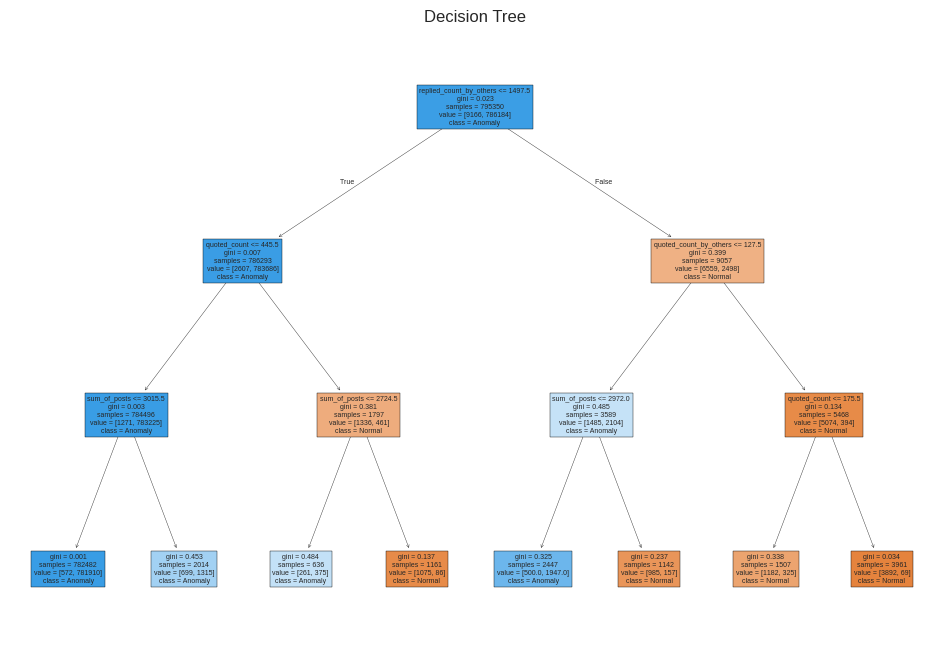

In [27]:
# Adjust labels to use for the Decision Tree
anomaly_labels = np.where(anomalies == -1, 'Anomaly', 'Normal')

decision_tree = DecisionTreeClassifier(max_depth=3, random_state=42)
decision_tree.fit(numerical_features_df, anomaly_labels)    

tree_predictions = decision_tree.predict(numerical_features_df)
tree_accuracy = np.sum(anomaly_labels == tree_predictions) / len(anomaly_labels)

print(f"Decision Tree accuracy: {tree_accuracy*100:.2f}%")

# Create a DataFrame for feature importance for future uses
feature_importance = pd.DataFrame({
    'feature': numerical_features,
    'importance': decision_tree.feature_importances_
}).sort_values('importance', ascending=False)

# Create a copy for display purposes (formatted importance scores as percentages)
feature_importance_display = feature_importance.copy()
feature_importance_display['importance'] = feature_importance_display['importance'].apply(lambda x: f"{x*100:.1f}%")

print("\n=== Feature Importance ===")
print(feature_importance_display.to_string(index=False))

plot_tree(decision_tree, 
          feature_names=numerical_features,
          class_names=['Normal', 'Anomaly'],
          filled=True
          )  
plt.title("Decision Tree")
plt.show()

The surrogate DecisionTree can predict 99.7% of the IsolationForest's decisions. It almost perfectly mimics it.

Important features:
1. replied_count_by_others (67%):   
Normal users receive varied amounts of replies, but usually a moderate amount, whereas anomalous users either receive a lot (celebrities, influencers, etc.) or barely any replies (bots, inactive accounts)
3. quoted_count (14.8%):   
Most users quote a moderate amount, whereas anomalous users show very high or low rates
5. sum_of_posts (9.9%):    
Confirming our previous rule-based bot detection, we can see that extremely high (bots, power users) or low (lurkers, inactive accounts) post counts are anomalous

The three most important features are all non-sentiment scores, showing that it's not about _what_ people say, but about _how much_ they engage with the platform. Not a single sentiment score has any importance in the decision-making of either model.

#### Task 4.1.5. - Anomaly vs rule-based classification (3 points)
Evaluate how well these detected anomalies align with your existing `is_bot` labels from the rule-based approach.

Create a cross-tabulation (confusion matrix-style table) using `pd.crosstab()` and comparing those two classifications/labels. Interpret the results by writing two short observations, for example:
- How well do the two methods agree?
- Are there bots missed by one method but caught by the other?

In [28]:
# Use the previously declared anomaly_label variable that transformed -1/1 it into readable labels
crosstab_result = pd.crosstab(
    user_stats['is_bot'],
    anomaly_labels,
    colnames=[''],
    margins=True,
    )

crosstab_result.index = ['Non-Bot', 'Bot', 'Total']

print("\n=== Crosstable of Bot Detection Methods ===")
print(crosstab_result)

# Create a DataFrame to check index alignment and understand if the repeating 4976 is a coincidence
# or if it indicates a potential issue with the data alignment. Followed by a visual inspection of the 
# Debug DataFrame 
debug_df = pd.DataFrame({
    'is_bot': user_stats['is_bot'].values,
    'anomaly': anomaly_labels
})

print("\n=== Debugging ===")
print(f"Length debug_df: {len(debug_df)}")
print(f"Length user_stats['is_bot']: {len(user_stats['is_bot'])}")
print(f"Length anomaly_labels: {len(anomaly_labels)}")
print("\n")

print(debug_df.head(10))


=== Crosstable of Bot Detection Methods ===
         Anomaly  Normal     All
Non-Bot     4976  781208  786184
Bot         4190    4976    9166
Total       9166  786184  795350

=== Debugging ===
Length debug_df: 795350
Length user_stats['is_bot']: 795350
Length anomaly_labels: 795350


   is_bot  anomaly
0       0   Normal
1       0   Normal
2       0  Anomaly
3       0   Normal
4       0   Normal
5       1  Anomaly
6       0  Anomaly
7       0   Normal
8       0  Anomaly
9       1  Anomaly


The methods have a fairly limited agreement (only about 50% - 4190/9166).    
Each method captures different aspects of anomalous behavior:  
- 4976 Non-Bots classified as anomalous by identifying other unusual patterns (replied_count_by_others, quoted_count, etc.)
- 4976 Bots classified as normal: While they meet the rule-based criteria, they don't show any other anomalous behavior so the IsolationForest ignores them

#### Task 4.1.6. - Statistical test (2 points)

Test whether anomalies and non-anomalies differ significantly in `sentiment_mean` and `sentiment_std` similarly to Task 3.3. Visualize the distributions of `sentiment_mean` and `sentiment_std`, separately for anomalous users and non-anomalous users.

Like in Task 3.3 a Histogram was chosen to visualize the distributions.

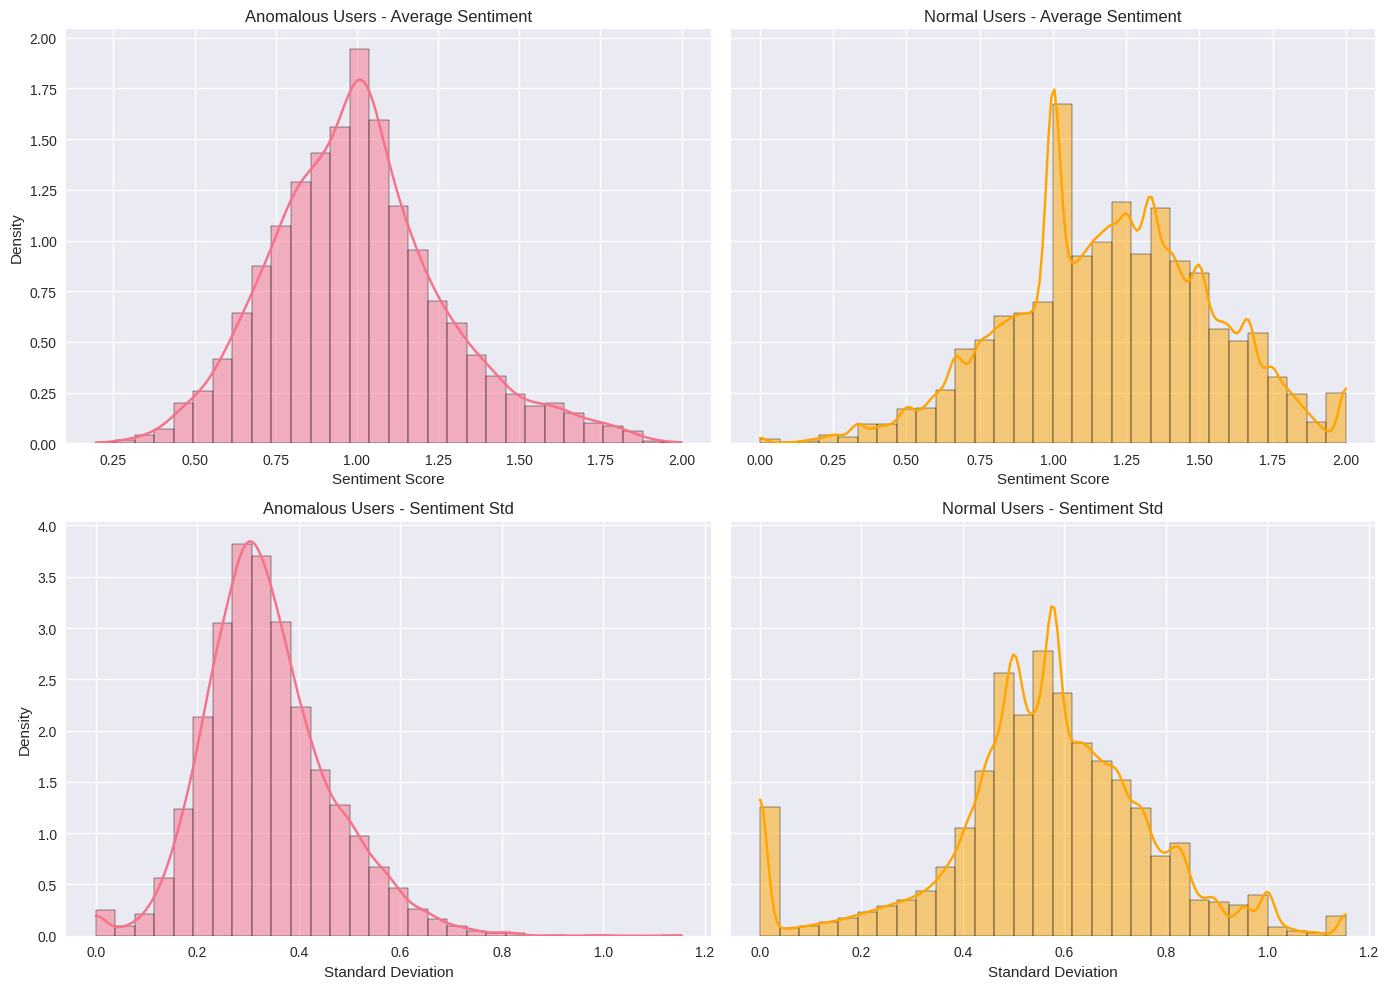


=== Mann-Whitney U Test Results ===
Average Sentiment Analysis:
Mann-Whitney U test p-value: 0.00
Effect size: 0.3533301823895134 (medium)

Standard Deviation of Sentiment Analysis:
Mann-Whitney U test p-value: 0.00
Effect size: 0.679326944279929 (large)


In [29]:
# Create copy of user_stats with anomaly labels for further analysis
forest_user_stats = user_stats.copy()   
forest_user_stats['anomaly'] = anomaly_labels

anomalous_sentiment_mean = forest_user_stats['avg_sentiment'][forest_user_stats['anomaly'] 
                                                              == 'Anomaly'].values
normal_sentiment_mean = forest_user_stats['avg_sentiment'][forest_user_stats['anomaly'] 
                                                           == 'Normal'].values

anomalous_std = forest_user_stats['std_of_sentiment'][forest_user_stats['anomaly'] 
                                                      == 'Anomaly'].values
normal_std = forest_user_stats['std_of_sentiment'][forest_user_stats['anomaly'] 
                                                   == 'Normal'].values

fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharey='row')

# Average Sentiment plots
sns.histplot(anomalous_sentiment_mean, bins=30, kde=True, stat='density', ax=axes[0,0])
sns.histplot(normal_sentiment_mean, bins=30, kde=True, stat='density', 
             ax=axes[0,1], color='orange')

axes[0,0].set_title('Anomalous Users - Average Sentiment')
axes[0,0].set_ylabel('Density')
axes[0,0].set_xlabel('Sentiment Score')

axes[0,1].set_title('Normal Users - Average Sentiment') 
axes[0,1].set_xlabel('Sentiment Score')

# Standard Deviation of Sentiment plots
sns.histplot(anomalous_std, bins=30, kde=True, stat='density', ax=axes[1,0])
sns.histplot(normal_std, bins=30, kde=True, stat='density', 
             ax=axes[1,1], color='orange')

axes[1,0].set_title('Anomalous Users - Sentiment Std')
axes[1,0].set_ylabel('Density')
axes[1,0].set_xlabel('Standard Deviation')

axes[1,1].set_title('Normal Users - Sentiment Std')
axes[1,1].set_xlabel('Standard Deviation')

plt.tight_layout()
plt.show()

# Mann-Whitney U test for non-parametric comparison - Effect size calculated and coded with Copilot
forest_sentiment_test = mannwhitneyu(anomalous_sentiment_mean, normal_sentiment_mean, 
                              alternative='two-sided')
forest_effect_size_sentiment = (1 - (2 * forest_sentiment_test.statistic) / 
                         (len(anomalous_sentiment_mean) * len(normal_sentiment_mean)))

forest_std_test = mannwhitneyu(anomalous_std, normal_std, alternative='two-sided')
forest_effect_size_std = 1 - (2 * forest_std_test.statistic) / (len(anomalous_std) * len(normal_std))

print("\n=== Mann-Whitney U Test Results ===")
print("Average Sentiment Analysis:")
print(f"Mann-Whitney U test p-value: {forest_sentiment_test.pvalue:.2f}")
print(f"Effect size: {forest_effect_size_sentiment} ({interpret_effect_size(forest_effect_size_sentiment)})")
print("\nStandard Deviation of Sentiment Analysis:")
print(f"Mann-Whitney U test p-value: {forest_std_test.pvalue:.2f}")
print(f"Effect size: {forest_effect_size_std} ({interpret_effect_size(forest_effect_size_std)})")

Like in Task 3.3. I chose the Mann-Whitney U test because normality is not a requirement and it works well for comparing two independent groups with continuous data. 

There are significant differences in the behavioral patterns of anomalous and normal users (p-value < 0.05). The effect sizes are also meaningful. We can see that there's a medium effect for the average sentiment and a large effect for the standard deviation of sentiment. This means that there's a moderate difference in average sentiment across the two groups but a strong difference in sentiment variability. Anomalous users are way more erratic in their emotional patterns.

### Task 4.2. - User Segmentation Analysis (25 points)

The management team at Bluesky wants to gain deeper insights into their user base and has enlisted your help as a data analyst. They are particularly interested in identifying different types of users based on their behavior patterns.

You have already used an Isolation Forest to detect anomalous users. Now, you will perform a comprehensive user segmentation analysis by following these guided steps:


#### Task 4.2.1. - Data Preparation (3 points)
Rerun the Isolation Forest using `contamination='auto'` to identify anomalous users. Focus your subsequent analysis on the users **not** identified as outliers by the model, as these represent more typical user behavior patterns.

- Apply the Isolation Forest with `contamination='auto'` 
- Report how many users are classified as anomalous vs. normal
- Create a subset containing only the normal (non-anomalous) users for clustering


In [30]:
auto_iso_forest = IsolationForest(
    contamination='auto',
    random_state=42,
    n_jobs=-1 # Use all available cores
)

auto_anomalies = auto_iso_forest.fit_predict(numerical_features_df)
auto_anomaly_scores = auto_iso_forest.decision_function(numerical_features_df)

auto_normal_users = auto_anomalies == 1
auto_anomalous_users = auto_anomalies == -1

print("=== Isolation Forest Results (automatic contamination rate) ===")
print(f"Total users: {len(auto_anomalies)}")
print(f"Normal users: {sum(auto_normal_users)}")
print(f"Anomalous users: {sum(auto_anomalous_users)}")
print(f"Percentage of anomalies: {(sum(auto_anomalous_users) / len(auto_anomalies) * 100):.2f}%")

# Adjust labels, then add to user_stats and extract the subset of normal users
auto_anomaly_labels = np.where(anomalies == -1, 'Anomaly', 'Normal')
user_stats['auto_anomaly'] = auto_anomaly_labels
normal_user_stats = user_stats[auto_anomaly_labels == 'Normal'].copy()

normal_user_stats.head()

=== Isolation Forest Results (automatic contamination rate) ===
Total users: 795350
Normal users: 744433
Anomalous users: 50917
Percentage of anomalies: 6.40%


,user_id,avg_sentiment,std_of_sentiment,sum_of_posts,avg_number_of_posts_per_day,active_days,mean_days_between_posts,median_days_between_posts,std_days_between_posts,cv_days_between_posts,time_between_first_and_last_post,replied_count,reposted_count,quoted_count,author,replied_count_by_others,reposted_count_by_others,quoted_count_by_others,is_bot,auto_anomaly
0,0,0.406316,0.235153,1404,11.414634,123,1.245902,1.0,2.626349,2.107991,152,76.0,1398.0,306.0,0.0,8.0,4.0,0.0,0,Normal
1,1,0.898177,0.507907,512,3.390728,151,1.733333,1.0,4.669861,2.694151,260,94.0,81.0,18.0,1.0,313.0,505.0,160.0,0,Normal
3,3,1.217184,0.644854,10,1.250000,8,1.714286,1.0,1.112697,0.649073,12,0.0,0.0,0.0,3.0,89.0,340.0,79.0,0,Normal
4,4,1.514687,0.522817,290,2.685185,108,1.971963,1.0,1.390384,0.705076,211,188.0,12.0,10.0,4.0,1788.0,17091.0,2463.0,0,Normal
7,7,1.415904,0.490753,314,9.235294,34,3.090909,1.0,10.944073,3.540729,102,165.0,18.0,2.0,7.0,261.0,461.0,15.0,0,Normal


#### Task 4.2.2. - Feature Engineering (5 points)
Create a subset of features for clustering that capture user behavior patterns:

- Calculate `total_interactions` as the sum of `replied_count`,` reposted_count`, and `quoted_count`
- Create interaction ratio features:
  - `reply_ratio` = replied_count / total_interactions (handle division by zero)
  - `repost_ratio` = reposted_count / total_interactions  
  - `quote_ratio` = quoted_count / total_interactions
- Apply log transformation to the interaction counts (add 1 before logging to handle zeros)
- Explain why these transformations are useful for clustering and understanding users


In [31]:
interaction_cols = ['replied_count', 'reposted_count', 'quoted_count']
total_interactions = normal_user_stats[interaction_cols].sum(axis=1)

# Calculate ratios and handle division by zero (replace NaN with 0)
ratios = normal_user_stats[interaction_cols].div(total_interactions.replace(0, np.nan), axis=0) 
ratios = ratios.fillna(0)

ratios.columns = ['reply_ratio', 'repost_ratio', 'quote_ratio']

# Log transform features (add 1 to handle zeros)
log_interactions = np.log(normal_user_stats[interaction_cols] + 1)
log_interactions.columns = ['log_replied', 'log_reposted', 'log_quoted']
log_total_interactions = np.log(total_interactions + 1)

# Combine all features into a single DataFrame
behavior_features_df = pd.concat([
    log_total_interactions.rename('log_total_interactions'),
    log_interactions,
    ratios
], axis=1)

behavior_features_df.head()

,log_total_interactions,log_replied,log_reposted,log_quoted,reply_ratio,repost_ratio,quote_ratio
0,7.484930,4.343805,7.243513,5.726848,0.042697,0.785393,0.171910
1,5.267858,4.553877,4.406719,2.944439,0.487047,0.419689,0.093264
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,5.351858,5.241747,2.564949,2.397895,0.895238,0.057143,0.047619
7,5.225747,5.111988,2.944439,1.098612,0.891892,0.097297,0.010811


As we established in Task 2.4. our interaction data is heavily right-skewed and a Log-transformation makes them more _normal_. Without it, anomalous users with thousands of interactions would dominate the scale of the clustering algorithm and it would become almost impossible to tell the difference between them and normal users. 


#### Task 4.2.3. - Optimal Cluster Selection (8 points)
Determine the optimal number of clusters using the silhouette method. The silhouette method evaluates clustering quality to help choose the optimal number of clusters k. It balances intra-cluster cohesion and inter-cluster separation. A silhouette score is calculated per k and a score close to 1 signals well-separated clusters, a score close to 0 means overlapping clusters and a negative score indicates misclassified clusters.

- take the features `log_replied`, `log_reposted`, `log_quoted`, `reply_ratio`, `repost_ratio`, `quote_ratio`
- sample a subsample of 100_000 users to increase the speed of clustering
- perform a `StandardScaler` on them
- Test k-means clustering for k = 2 to 8
- Calculate silhouette scores for each k
- Plot the silhouette scores and the inertia scores and select the optimal k
- Justify your choice of the optimal number of clusters


Silhouette score for k=2: 0.3311
Silhouette score for k=3: 0.3677
Silhouette score for k=4: 0.3893
Silhouette score for k=5: 0.4307
Silhouette score for k=6: 0.3903
Silhouette score for k=7: 0.3886
Silhouette score for k=8: 0.3910


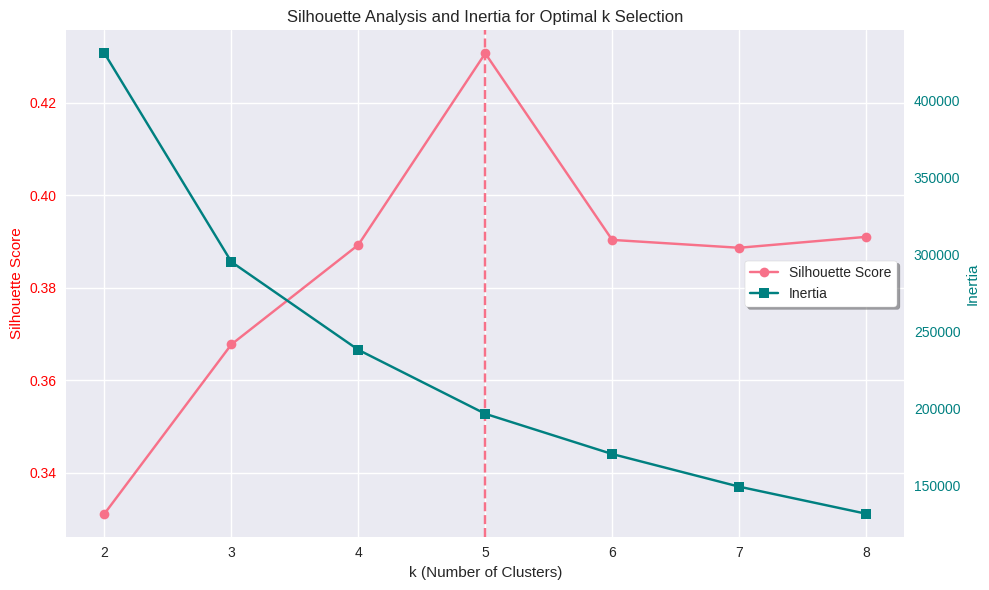


Optimal k based on silhouette score: 5
Corresponding inertia: 196725.2493


In [32]:
sample_behavior_features = behavior_features_df.drop('log_total_interactions', 
                                                     axis=1).sample(100000, random_state=42)

scaler = StandardScaler()
scaled_features = scaler.fit_transform(sample_behavior_features)

k_values = range(2, 9)

# Create dictionaries to save the scores with their corresponding k's
silhouette_dict = {}
inertia_dict = {} 

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    
    silhouette = silhouette_score(scaled_features, kmeans.labels_)
    silhouette_dict[k] = silhouette
    inertia_dict[k] = kmeans.inertia_
    print(f"Silhouette score for k={k}: {silhouette:.4f}")
    
# Create dual-axis plot - Done with the help of Copilot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot silhouette scores on primary y-axis
ax1.set_xlabel('k (Number of Clusters)')
ax1.set_ylabel('Silhouette Score', color='red')
line1 = ax1.plot(list(silhouette_dict.keys()), list(silhouette_dict.values()), 
                 'o-', label='Silhouette Score', zorder=1)
ax1.tick_params(axis='y', labelcolor='red')

# Create secondary y-axis for inertia
ax2 = ax1.twinx()
ax2.set_ylabel('Inertia', color='teal')
line2 = ax2.plot(list(inertia_dict.keys()), list(inertia_dict.values()), 
                 's-', color='teal', label='Inertia', zorder=2)
ax2.tick_params(axis='y', labelcolor='teal')

best_k = max(silhouette_dict, key=silhouette_dict.get)
ax1.axvline(x=best_k, linestyle='--')

lines = line1 + line2
labels = [label.get_label() for label in lines]
ax1.legend(lines, labels, loc='center right', frameon=True, shadow=True, facecolor='white')

plt.title('Silhouette Analysis and Inertia for Optimal k Selection')
plt.grid(False)
plt.tight_layout()
plt.show()

print(f"\nOptimal k based on silhouette score: {best_k}")
print(f"Corresponding inertia: {inertia_dict[best_k]:.4f}")

Our optimal k is 5 because it has the highest average silhouette score. So, on average, the points for k=5 are the most similar to their cluster. 

We can also see that the inertia decreases the higher our k is, but the difference between 5 and 6,7,8 is too small to matter compared to the major differences in silhouette scores.


#### Task 4.2.4. - Clustering and Visualization (5 points)
Apply k-means clustering with your optimal k and create visualizations:

- Apply k-means with the optimal k
- Create at least two different visualizations of your clusters:
  - PCA projection (2D scatter plot colored by cluster)
  - One additional visualization of your choice (t-SNE, UMAP, or cluster characteristic plots)


In [ ]:
optimal_kmeans = KMeans(best_k, random_state=42)
optimal_labels = optimal_kmeans.fit_predict(scaled_features)

# Reduce dimensionality with PCA
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)
pca_centers = pca.transform(optimal_kmeans.cluster_centers_)

# Reduce dimensionality with UMAP
umap_reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
umap_features = umap_reducer.fit_transform(scaled_features)

# Plotting Preparation - Done with the help of Copilot
# Create DataFrames for PCA and UMAP results for visualization
pca_df = pd.DataFrame({
    'PCA1': pca_features[:, 0],
    'PCA2': pca_features[:, 1],
    'cluster': optimal_labels
})

umap_df = pd.DataFrame({
    'UMAP1': umap_features[:, 0],
    'UMAP2': umap_features[:, 1],
    'cluster': optimal_labels
})

# Meaningful cluster names
cluster_names = {
    0: 'Power Users',
    1: 'Quoters', 
    2: 'Conversationalists',
    3: 'Informers',
    4: 'Lurkers/Inactive Users',
}

# Map numeric clusters to string names for plotting
pca_df['cluster_name'] = pca_df['cluster'].map(cluster_names)
umap_df['cluster_name'] = umap_df['cluster'].map(cluster_names)

# Calculate UMAP centroids for visualization
umap_centroids = umap_df.groupby('cluster')[['UMAP1', 'UMAP2']].mean()

# Create a color map for clusters and centroid markers
unique_clusters = sorted(cluster_names.keys())
colors = sns.color_palette('husl', n_colors=len(unique_clusters))
color_map = {cluster_names[cluster_id]: color for cluster_id, color in zip(unique_clusters, colors)}

# Plotting - Done with the help of Copilot
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# PCA visualization
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='cluster_name', 
                palette=color_map, alpha=0.6, ax=axes[0])

# Plot centroids with their corresponding cluster colors and black borders
for cluster_id in unique_clusters:
    center = pca_centers[cluster_id]
    color = color_map[cluster_names[cluster_id]]
    axes[0].scatter(center[0], center[1], marker='x', s=250, c='black', linewidths=4)
    axes[0].scatter(center[0], center[1], marker='x', s=160, c=color, linewidths=2)

# Add a single centroid marker for the legend    
axes[0].scatter([], [], marker='x', s=150, facecolors='black', 
               edgecolors='k',linewidth=2, label='Centroids')

axes[0].set_title('K-Means Clusters - PCA Projection')
axes[0].legend(frameon=True, shadow=True, bbox_to_anchor=(1.05, 1), 
               loc='upper left')

# UMAP visualization
sns.scatterplot(data=umap_df, x='UMAP1', y='UMAP2', hue='cluster_name', 
                palette=color_map, alpha=0.6, ax=axes[1])

# Add colored centroids with black borders for UMAP
for cluster_id, center in umap_centroids.iterrows():
    color = color_map[cluster_names[cluster_id]]
    axes[1].scatter(center['UMAP1'], center['UMAP2'], marker='x', s=250, c='black', linewidths=4)
    axes[1].scatter(center['UMAP1'], center['UMAP2'], marker='x', s=160, c=color, linewidths=2)
  

# Add a single legend entry for all centroids
axes[1].scatter([], [], marker='x', s=150, facecolors='black',
               edgecolors='k', linewidth=2, label='Centroids')

axes[1].set_title('K-Means Clusters - UMAP Projection')
axes[1].legend(frameon=True, shadow=True, bbox_to_anchor=(1.05, 1), 
               loc='upper left')

plt.tight_layout()
plt.show()

We can see clear clusters in both graphics.  
PCA Projection:  
One major cluster on the right side (balanced users?) and smaller clusters to the left (outliers?). The smallest cluster might depict very active power users. One cluster is spread inside all others - I'm uncertain what this could mean.

UMAP:  
The major cluster from the PCA Projection is now in the center of the graph, with the other clusters spread around it. This further supports my hypothesis that it depicts the average user as they form the central core in the high-dimensional feature space. We can see the smallest cluster far away from the others in the UMAP graph as well. This shows that the users in this cluster are the least similar to the others. This could, however, also describe the Quoters, which is the only user type (besides power users) that heavily uses the Quoting feature.


#### Task 4.2.5. - Cluster Interpretation (4 points)
Analyze and interpret your clusters to provide actionable insights:

- Calculate mean values of key features for each cluster and plot them
- Plot the proportions of how many users belong to each cluster
- Describe what characterizes each cluster (e.g., high/low activity, behavior preferences)
- Give each cluster a meaningful name that reflects their behavior pattern

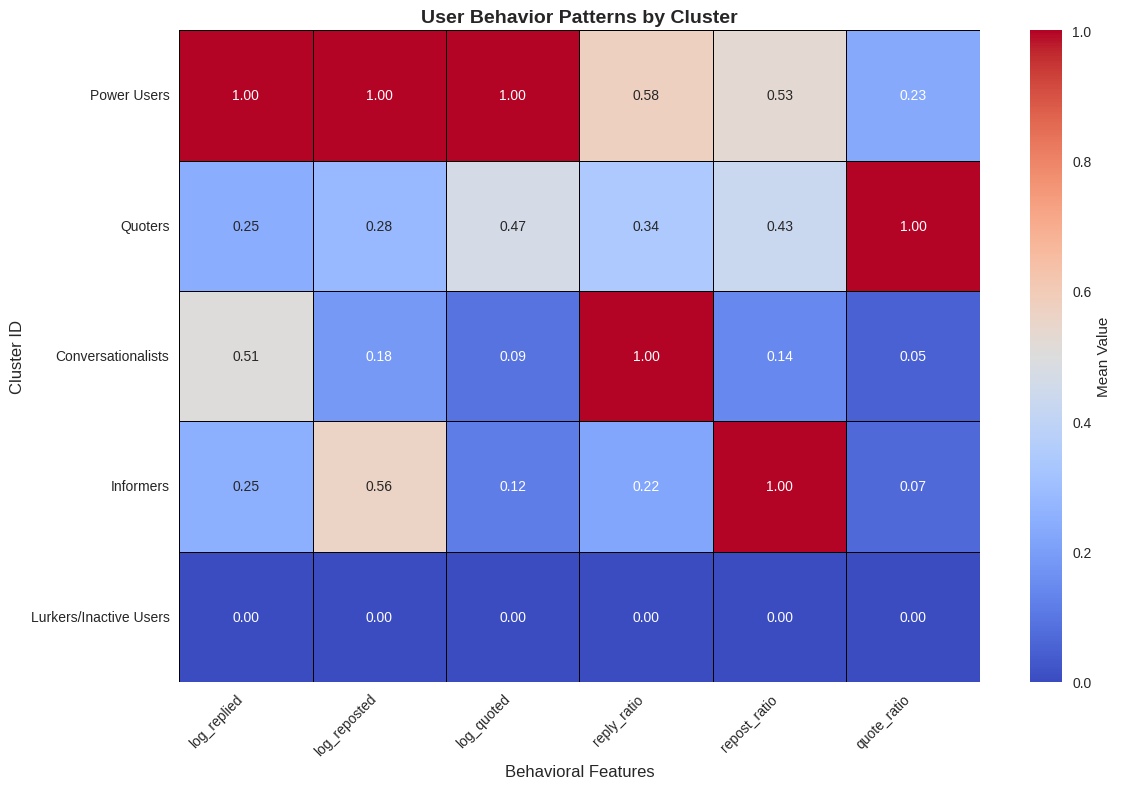

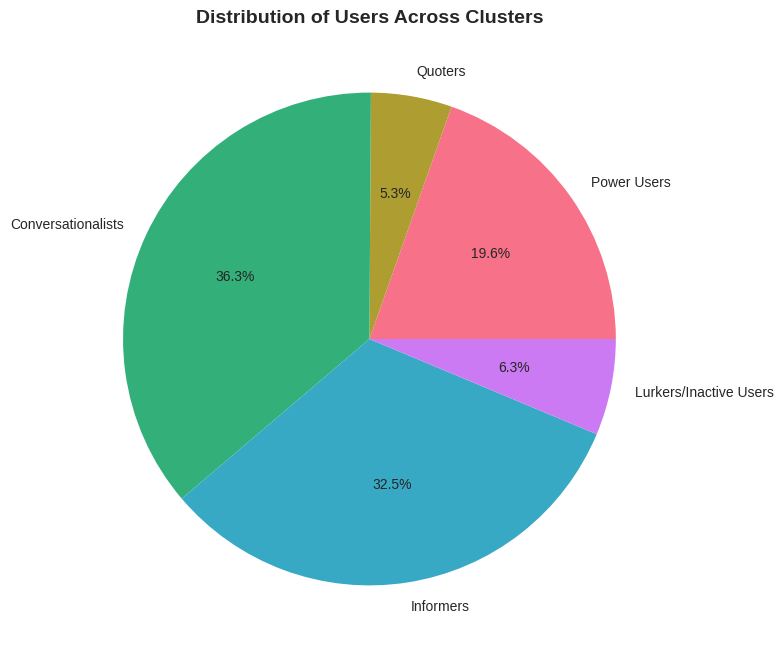

In [34]:
# Prepare data
clustered_data = sample_behavior_features.copy()
clustered_data['cluster'] = optimal_labels

# Cluster proportions
cluster_counts = clustered_data['cluster'].value_counts().sort_index()
cluster_proportions = cluster_counts / cluster_counts.sum()

# Map cluster IDs to names
cluster_labels = [cluster_names[i] for i in cluster_proportions.index]

# Mean of Key Features by Cluster
cluster_means = clustered_data.groupby('cluster').mean().reset_index()

# Normalize the cluster means for better visualization (Min-Max Scaling)
# Min-Max applicable because we are working with aggregate data (means)
cluster_means_normalized = cluster_means.drop(columns='cluster').copy()
for col in cluster_means_normalized.columns:
    cluster_means_normalized[col] = (cluster_means_normalized[col] - cluster_means_normalized[col].min()) / \
                                   (cluster_means_normalized[col].max() - cluster_means_normalized[col].min())

# Heatmap Visualization of Mean Values of Key Features
sns.heatmap(cluster_means_normalized, 
           annot=True, fmt='.2f', cmap='coolwarm', 
           cbar_kws={'label': 'Mean Value'}, 
           linewidths=0.5, linecolor='black',
           yticklabels=cluster_labels)

plt.title('User Behavior Patterns by Cluster', fontsize=14, fontweight='bold')
plt.ylabel('Cluster ID', fontsize=12)
plt.xlabel('Behavioral Features', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0) 
plt.tight_layout()
plt.show()

# Pie Chart Visualization of Cluster Proportions
fig, ax = plt.subplots(figsize=(8, 8))

wedges, texts, autotexts = ax.pie(cluster_proportions.values, 
                                  labels=cluster_labels,
                                  autopct='%1.1f%%',
                                  colors=sns.color_palette('husl', n_colors=len(cluster_proportions)))

ax.set_title('Distribution of Users Across Clusters', fontsize=14, fontweight='bold')
plt.show()

User Types:  

- Lurkers/Inactive Users:  
No Replies, Reposts or Quotes  
Provide no engagement. They either don't want to interact or don't use their account. 
- Conversationalists:  
Active users who reply frequently but neither quote nor repost often.  
Provide medium engagement and spend most of their interaction replying to other posts.
- Informers:  
Active users who repost frequently but neither quote nor reply extensively. However, they show a greater ratio in their other two proportional behavioral features than Repliers do.  
Provide medium engagement and are focused on reposting other people's content.
- Quoters:  
Active users who quote frequently but neither reply nor repost often. However, they show an even greater ratio in their other two proportional behavioral features than Reposters do. 
Provide medium engagement and mainly add their opinions by quoting other posts.
- Power Users:  
Very active users who provide a lot of engagement through all possible avenues.

An interesting observation is that every user type, besides Quoters, will use the Quoting function less than the other two behavioral features.